<font size="6">****Modelling the Covid-19 Pandemic****</font>  

<font size="5">****An Analysis of the Efficacy of Covid-19 related Government Measures****</font> 
<br>
<br>
<br>
<font size="3">****Table of Contents****</font>  
1. [Introduction](#introduction)
2. [Theoretical framework](#theoretical_framework)  
&nbsp;&nbsp;&nbsp;2.1 [The SIRF model](#the_sirf_model)  
&nbsp;&nbsp;&nbsp;2.2 [Parameters and ordinary differential equation system](#parameters_and_ordinary_differential_equation_system)  
&nbsp;&nbsp;&nbsp;2.3 [Parameter variation](#parameter_variation)  
&nbsp;&nbsp;&nbsp;2.4 [Parameter hyperestimation](#parameter_hyperestimation)  
3. [Empirical analysis](#empirical_analysis)  
&nbsp;&nbsp;&nbsp;3.1 [Data](#data)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1.1 [Data sources, variables description and sample construction](#data_sources_variables_description_and_sample_construction)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1.2 [Data visualizations](#data_visualizations)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1.3 [Descriptive statistics](#descriptive_statistics)  
&nbsp;&nbsp;&nbsp;3.2 [SIRF model parameter estimation and visualization](#sirf_model_parameter_estimation_and_visualization)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.1 [Parameter estimation](#parameter_estimation)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.2 [Data inspection](#data_inspection)  
&nbsp;&nbsp;&nbsp;3.3 [Effect of government quality on efficacy of government intervention](#effect_of_government_quality_on_efficacy_of_government_intervention)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3.1 [Dependent variable](#dependent_variable)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3.1 [Independent variables](#independent_variables)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3.3 [Multiple linear regression model](#multiple_linear_regression_model)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3.4 [Multiple linear regression model with continent fixed effects](#multiple_linear_regression_model_with_continent_fixed_effects)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3.5 [Multiple linear regression model with interaction effects](#multiple_linear_regression_model_with_interaction_effects)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3.6 [Regression diagnostics](#regression_diagnostics)  
&nbsp;&nbsp;&nbsp;3.4 [Scenario analysis](#scenario_analysis)  
4. [Conclusion](#conclusion)  

<a id="introduction"></a>
# Introduction

The sudden and unexpected emergence of the novel coronavirus in December 2019 caused severe adverse effects on economies and public health around the world from early 2020 to the present day (see, e.g., [Chudik, Mohaddes, Hashem et al. (2020)](https://www.nber.org/papers/w27855) and [Huang, Huang, Wang et al. (2021)](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)32656-8/fulltext)). Two effective ways to dampen the spread of the coronavirus are government interventions (see, e.g., [Haug, Geyrhofer, Londei et al. (2020)](https://www.nature.com/articles/s41562-020-01009-0)) and vaccines (see, e.g., [Rossman, Shilo, Meir et al. (2021)](https://www.nature.com/articles/s41591-021-01337-2)). 

In this study, I investigate the effect of government quality on the efficacy of government interventions and predict the impact of a lockdown, medicine and vaccine scenario on several coronavirus-related variables, such as confirmed or fatal cases. To identify these effects, I collect daily panel data on 199 countries, employ the SIRF model, which is a workhorse model for explaining infectious diseases, and run regressions. I find that the government quality variables ecological footprint of consumption increases, legislative size increases and political globalization decreases the efficacy of government interventions significantly. The scenario analysis shows that a lockdown, medicines or vaccines in May 2021 would significantly reduce the number of coronavirus infections and deaths in Switzerland over the next 360 days.

The remainder of this paper is structured as follows. In section 2, I introduce the SIRF model. Section 3 provides descriptive statistics on the coronavirus pandemic and presents the empirical results from the regressions and scenario analysis. Section 4 concludes.

**Import of modules**

In [1]:
import covsirphy as cs
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import json
import os
import pycountry as pyc
import pycountry_convert as pc
import random
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seabornfig2grid as sfg
import matplotlib.gridspec as gridspec
import geopandas as gpd
import mapclassify
from tqdm import tqdm
from datetime import timedelta
from datetime import datetime
from scipy import stats
from scipy.integrate import odeint
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.ticker import FormatStrFormatter
from covid19dh import covid19
from IPython.display import display
from IPython.display import Image
pd.options.mode.chained_assignment = None 

<a id='theoretical_framework'></a>
# Theoretical framework

The following section presents the theoretical concepts that are required to understand the empirical analysis in this paper. Specifically, this section introduces the SIRF model as a compartmental framework for modelling a pandemic. Moreover, particular attention is paid to the meaning and estimation of the model parameters. Finally, I provide a primer on the error measures that will be used to evaluate the model accuracy.

<a id='the_sirf_model'></a>
## The SIRF model

The SIRF model is a compartmental model belonging to a family of mathematical frameworks that model infectious diseases, such as pandemics. The SIRF model assigns individuals of a population to different compartments. Individuals either stay in a compartment for a certain amount of time or they progress between compartments. The transition between compartments is modelled by using ordinary differential equations. These equations suppose that the spread of a disease follows certain rules, which makes the development of a pandemic deterministic. Under the assumption that the rules of this model hold, it is possible to estimate important epidemiological parameters, such as the total number of susceptible, infected or recovered people, as well as crucial indicators, such as the reproductive number or the death rate. These types of models can serve as a basis for deriving recommendations for governmental public health interventions, which can affect the development of the epidemic. The SIRF model, as one of the simplest but most useful models, consists of four mutually exclusive and collectively exhaustive compartments of one population, which categorize individuals as of a particular point in time.

**Compartmental states**
- **Susceptible** ($S$): The number of susceptible individuals.
- **Uncategorized** ($U$): The number of infected and unconfirmed individuals.
- **Infected** ($I$): The number of infected and confirmed individuals.
- **Recovered** ($R$): The number of recovered and immune individuals.
- **Fatal** ($F$): The number of deceased individuals.

The predictive power of the SIRF model stems from the construction of an equation system that determines the transition between compartments over time. Consequently, the model assumes the progress of individuals between compartments to be dependent on transition rates which makes the stock of each compartment a function of the variable time ($t$). The flow of individuals between states can be illustrated as follows.

\begin{align*}
\large\mathrm{S} \overset{\beta I}{\longrightarrow}\mathrm{U}\overset{\alpha_1}{\longrightarrow}\ & \large\mathrm{F}    \\
\large\mathrm{U}\overset{1 - \alpha_1}{\longrightarrow}\ & \large\mathrm{I}\overset{\gamma}{\longrightarrow}\mathrm{R}    \\
& \large \mathrm{I}\overset{\alpha_2}{\longrightarrow}\mathrm{F}    \\
\end{align*}

**Endemic steady state**  
In epidemiology, an infection is said to be in an endemic steady state when the number of infected individuals is maintained at a constant level over time. It implies that one infectious individual must transmit the disease to one other person on average, hence the reproduction number equals $R_{0}=1$. In cases where a proportion of the population has already been immunized either because they were already infected or they were vaccinated, the critical condition for an endemic steady state transfers to $R_{0}*S=1$. Thereby, the size of the infected compartment remains constant. From a regulatory perspective, one can assume that the steady state represents a critical condition which must not be exceeded.

<a id="parameters_and_ordinary_differential_equation_system"></a>
## Parameters and ordinary differential equation system

**Parameter definitions**  
- **Effective contact rate** ($\beta$): The rate of effective infection [1/min].
- **Recovery rate** ($\gamma$): The recovery probability of infected and confirmed individuals [1/min].
- **Mortality rate of uncategorized individuals** ($\alpha_{1}$): The fatality probability of infected and unconfirmed individuals [1/min].
- **Mortality rate of infected individuals** ($\alpha_{2}$): The fatality probability of infected and confirmed individuals [1/min].
- **Discretizer** ($\tau$): Length of discrete time intervals [min].

**Reproduction number**  
The reproduction number of an infection, $R_{0}$, is the expected number of transmissions that are directly generated by one infectious individual in a population. $R_{0}>1$ indicates that the disease will be able to spread in a population. By contrast, when $R_{0}<1$, the number of infected individuals decreases. The reproduction number can be expressed by the following formula.

$R_0 = \rho (1 - \theta) (\sigma + \kappa)^{-1} = \beta (1 - \alpha_1) (\gamma + \alpha_2)^{-1}$

The reproduction number allows to determine the proportion of the population that should be immunized through vaccination to eradicate a disease. To prevent the spread, the proportion of a population that needs to be effectively vaccinated must be larger than $1-\frac{1}{R_{0}}$. Conversely, the proportion of the population that remains susceptible to the disease should be smaller than $\frac{1}{R_0}$.

**Ordinary differential equations**  
Under the assumption that the size of a compartmental state is differentiable with respect to time, the epidemic process becomes deterministic. Consequently, we can model the development of an epidemic by using the following set of ordinary differential equations.

\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}(1 - \alpha_1) \beta S I - (\gamma + \alpha_2) I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
& \frac{\mathrm{d}F}{\mathrm{d}T}= N^{-1}\alpha_1 \beta S I + \alpha_2 I  \\
\end{align*}

where $N=S+I+R+F$ represents the total population and $T$ describes the elapsed time from the start date.

**Parameter proxies**  
With the estimation of parameters, we can introduce can the following approximations.

- Set $(S, I, R, F) = N \times (x, y, z, w)$
- Set $(T, \alpha_1, \alpha_2, \beta, \gamma) = (\tau t, \theta, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$  

whereby the parameters are defined within the following ranges.  
- $0 \leq (x, y, z, w, \theta, \kappa, \rho, \sigma) \leq 1$
- $1\leq \tau \leq 1440$

**Programmatic implementation**  
The system of ordinary differential equations can be easily implemented in Python code. In order to do so, I define a function called `deriv` which generates the corresponding derivatives of each compartment as of a specific point in time.

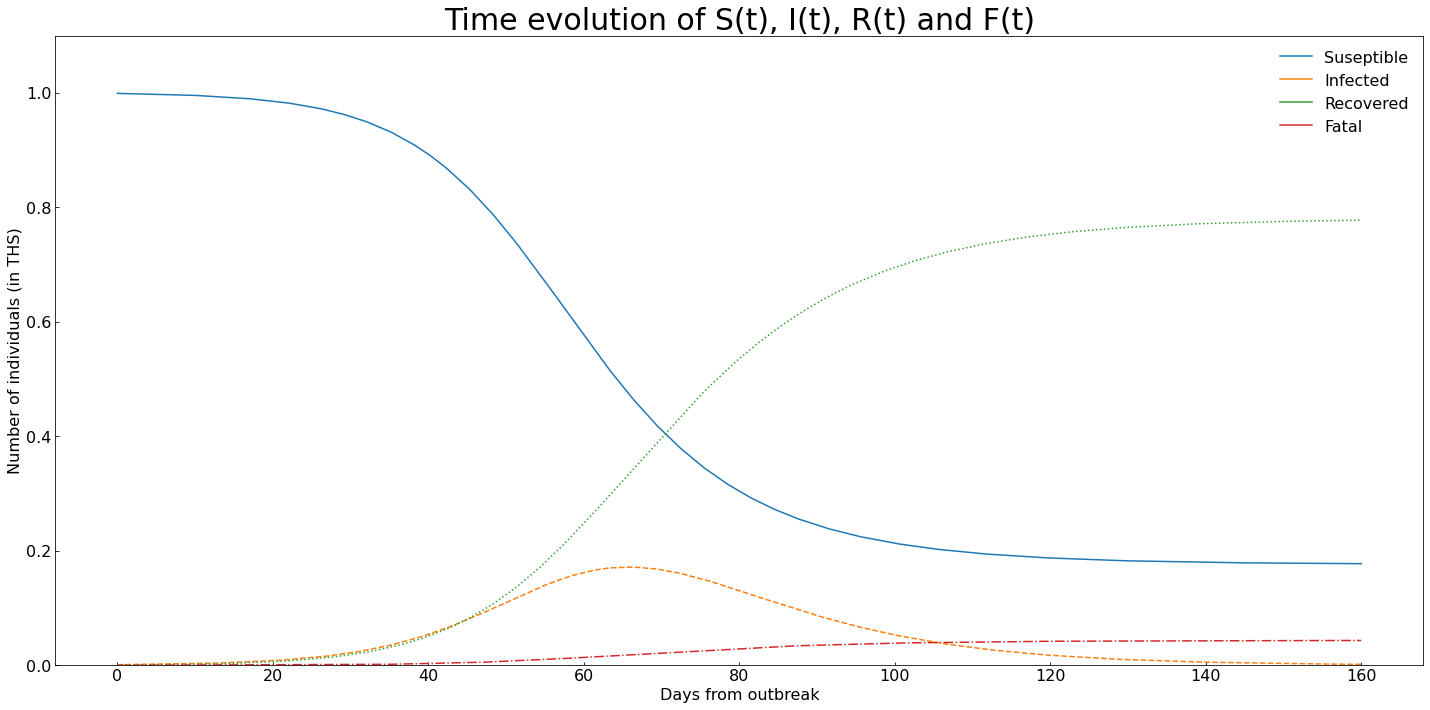

In [2]:
# Total population, N.
N = 1000

# Initial number of infected, recovered and fatal individuals.
I0, R0, F0 = 1, 0, 0

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0 - F0

# Effective contact rate, BETA, and mean recovery rate, GAMMA, (in 1/days).
ALPHA_1, ALPHA_2, BETA, GAMMA = .0002, .005, 0.2, .09 

# A grid of time points (in days).
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, ALPHA_1, ALPHA_2, BETA, GAMMA):
    S, I, R, F = y
    dSdt = -(N ** -1 * BETA * S * I)
    dIdt = N ** -1 * (1 - ALPHA_1) * BETA * S * I - (GAMMA + ALPHA_2) * I
    dRdt = GAMMA * I
    dFdt = N ** -1 * ALPHA_1 * BETA * S * I + ALPHA_2 * I
    return dSdt, dIdt, dRdt, dFdt

# Initial conditions vector
y0 = S0, I0, R0, F0

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, ALPHA_1, ALPHA_2, BETA, GAMMA))
S, I, R, F = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x = t, y = S/1000, label='Suseptible')
sns.lineplot(x = t, y = I/1000, label='Infected')
sns.lineplot(x = t, y = R/1000, label='Recovered')
sns.lineplot(x = t, y = F/1000, label='Fatal')

# Add figure annotations
ax.set_title('Time evolution of S(t), I(t), R(t) and F(t)', fontdict={'fontsize': 30})
ax.set_xlabel('Days from outbreak', fontsize=16)
ax.set_ylabel('Number of individuals (in THS)', fontsize=16)
ax.set_ylim(0, 1.1)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=16)

ax.lines[0].set_linestyle('solid')
ax.lines[1].set_linestyle('dashed')
ax.lines[2].set_linestyle('dotted')
ax.lines[3].set_linestyle('dashdot')

plt.tight_layout()

Notable is that the time development of model variables follow a distinct pattern. In a next step, I will illustrate how this can change if I impute variations in parameter values.

<a id="parameter_variation"></a>
## Parameter variation

To illustrate how the epidemic process is influenced by the parameters of the model, the following section will provide four scenarios and plot the results.

**Examplary scenarios**
- **Mortality rate of uncategorized**: $(\theta, \kappa, \rho, \sigma) = (0.0600, 0.005, 0.20, 0.075)$
- **Mortality rate of infected**: $(\theta, \kappa, \rho, \sigma) = (0.0002, 0.050, 0.20, 0.075)$
- **Effective contact rate**: $(\theta, \kappa, \rho, \sigma) = (0.0002, 0.005, 0.40, 0.075)$
- **Recovery rate**: $(\theta, \kappa, \rho, \sigma) = (0.0002, 0.005, 0.20, 0.140)$

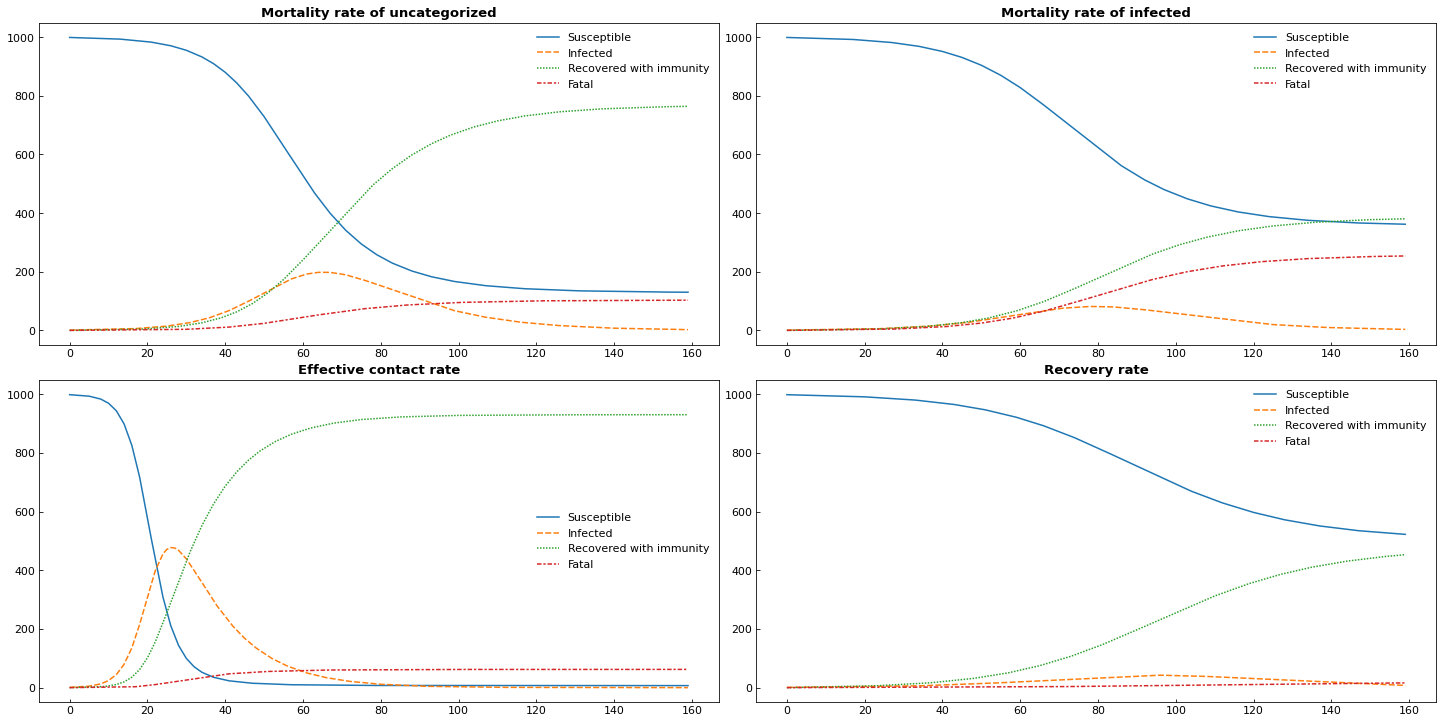

In [3]:
scenarios = {'Mortality rate of uncategorized':  (0.0600, 0.005, 0.20, 0.075),
             'Mortality rate of infected':       (0.0002, 0.050, 0.20, 0.075),
             'Effective contact rate':           (0.0002, 0.005, 0.40, 0.075),
             'Recovery rate':                    (0.0002, 0.005, 0.20, 0.140)}

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(20,10))

for iIteration, iScenario in enumerate(scenarios):
    ALPHA_1, ALPHA_2, BETA, GAMMA = scenarios[iScenario]
    ret = odeint(deriv, y0, t, args=(N, ALPHA_1, ALPHA_2, BETA, GAMMA))
    df = pd.DataFrame(ret, columns=['Susceptible', 'Infected', 'Recovered with immunity', 'Fatal'])    
    sns.lineplot(data=df, ax=eval(f'ax{iIteration}'))
    eval(f"ax{iIteration}.set_title('{iScenario}', fontweight='bold')")

fig.tight_layout(pad=0.5)

**The mortality rate of uncategorized individuals** ($\theta$)  
I observe that an increase in mortality rates of uncategorized individuals has only a limited impact on fatal cases. The reason for this insignificant effect is that mortality rates of uncategorized individuals are low by assumption. Most of Covid-19 deaths can be attributed to a previous confirmed infection, and hence also a large percentual increase of uncategorized mortality does not significantly impact total fatal cases.

**The mortality rate of infected individuals** ($\kappa$)  
An increase in mortality rates of infected individuals seems to invoke larger changes in the dynamics of the model. First, individuals which are in the infected compartment experience a greater probability of dying rather than recovering. Hence, the model transfers individuals from the recovered compartment to the fatal compartment. Second, it seems that an increased mortality rate has a positive effect on the number of susceptible individuals. This is the case because a disease cannot spread through the entire population if its mortality rate is high, as infected individuals do not transfer the disease but die.

**Effective contact rate** ($\rho$)  
An increase in the effective contact rate increases the probability of the disease to be transmitted from infected to susceptible individuals. Hence, the magnitude of individuals in the infected compartment increases significantly. At the same time, the number of susceptible individuals decreases and the number of recovered individuals increases. This results in a population being entirely immunized against a disease because the largest part of the population has been infected but recovered successfully. In this case the proportion of immunized individuals will soon be large enough to dampen the spread of a disease and achieve the so-called herd immunity. The effective contact rate is largely determined by social contact patterns of a particular society, hence government restrictions can have a meaningful influence on the spread of the epidemic process.

**Recovery rate** ($\sigma$)  
An increase in recovery rates results in a higher probability of individuals to recover from a disease. Hence, individuals are transferred from the fatal compartment to the recovered compartment.

**Effect of specific scenarios on model parameters**  
Government measures have a significant impact on the parameters of the model. For the simulations conducted in this paper, we can assume the following relationships.
- **Lockdown**: A lockdown scenario halves the effective contact rate because individuals are required to limit social contact patterns.
- **Medicine**: A medicine scenario reduces the mortality rate of infected individuals and increases the recovery rate at the same time.
- **Vaccine**: A vaccine scenario reduces the effective contact rate, reduces the mortality rate of infected individuals and increases the recovery rate.

The following figure summarizes the impact of specific scenarios on model parameters.

| Scenario | Parameter change                                   |
|----------|----------------------------------------------------|
| Lockdown | $\rho * 0.5$                                       |
| Medicine | $\kappa * 0.5$ and $\sigma * 2$                    |
| Vaccine  | $\rho * 0.8$ and $\kappa * 0.6$ and $\sigma * 1.2$ |

<a id="parameter_hyperestimation"></a>
## Parameter hyperestimation

For the estimation of the model parameters, the relationship between susceptible ($S$) and recovered ($R$) individuals determines the parameter values. Parameter optimization occurs within certain time phases in which the flow from the initial compartment ($S$) to the final compartment ($R$) is constant. The Root Mean Squared Log Error (RMSLE) shown below serves as the relevant cost function for the optimization algorithm.

$$ \text{RMSLE} = \sqrt{\cfrac{1}{n}\sum_{i=1}^{n}(log_{10}(A_{i} + 1) - log_{10}(P_{i} + 1))^2} $$

where 
- $A$ is observed (actual) values
- $P$ is estimated (predicted) values. 
- Variables are $S$ ($i=1$), $I$ ($i=2$), $R$ ($i=3$) and $F$ ($i=n=4$) for the SIRF model. 

By applying the RMSLE, prediction errors are not penalized much more severly in cases where the predicted and actual values are large numbers. This is the case because the RMSLE focuses on the relative error between the predicted and actual values, hence the scale of the error is insignificant. At the same time, the biasing effect of outliers is drastically reduced. A second point for why this metric is advantageous for the computations at hand is that the RSMLE imposes a biased error. The RMSLE incurs stricter penalties for underestimation than for overestimation, which is particularly useful for the analysis of COVID-19 data where overestimating the target variable, such as the number of coronavirus cases, is often preferred over underestimating it.

For a more detailed description of the optimization algorithm, see the paper from ([Balkew and Mogessie (2010)](https://dc.etsu.edu/cgi/viewcontent.cgi?article=3102&context=etd)).

<a id="empirical_analysis"></a>
# Empirical analysis

The following section inherits the empirical part of this paper. First, I collect daily panel data on 199 countries, employ the SIRF model, which is a workhorse model for explaining infectious diseases, and run regressions. I find that the government quality variables ecological footprint of consumption increases, legislative size increases and political globalization decreases the efficacy of government interventions significantly. The scenario analysis shows that a lockdown, medicines or vaccines in May 2021 would significantly reduce the number of coronavirus infections and deaths in Switzerland over the next 360 days.

<a id="data"></a>
## Data

<a id="data_sources_variables_description_and_sample_construction"></a>
### Data sources, variables description and sample construction

The main dataset consists of daily panel data on 199 countries and stems from the Covid-19 Data Hub ([Guidotti and Ardia (2020)](https://covid19datahub.io)). The dataset includes various Covid-19 variables, such as the cumulative number of confirmed cases and deaths, and information on policy measures and geography of each country. One important variable that will be used in the parameter estimation section is the stringency index. This variable ranges between 0 and 100 and measures the stringency of the Covid-19 government measures. A higher stringency index indicates more severe government measures. In this section, I work solely with the Covid-19 Data Hub dataset (C19DH), while in the regression and scenario analysis sections, I employ the [CovsirPhy](https://lisphilar.github.io/covid19-sir/index.html) package which is based primarily on the C19DH and data on the number of tests and vaccinations from Our World in Data ([Hasell, Mathieu and Beltekian (2020)](https://github.com/owid/covid-19-data/tree/master/public/data)). For the government quality variables, I use the QoG Expert Survey from the University of Gothenburg. This dataset is described in more detail in the section where the regressions are run.

I import the variables of interest of the raw C19DH and display the first five observations of France and the United States. 

In [4]:
rawCovidData = pd.read_csv('../data/raw_data/covid19_dataset.csv', parse_dates=['date'], 
                           usecols=['id', 'date', 'confirmed', 'deaths', 'population', 'administrative_area_level_1'])

display(rawCovidData.loc[rawCovidData['id'] == 'FRA'].head())
display(rawCovidData.loc[rawCovidData['id'] == 'USA'].head())

,id,date,confirmed,deaths,population,administrative_area_level_1
30470,FRA,2020-01-22,NaN,NaN,66977107,France
30471,FRA,2020-01-23,1.0,NaN,66977107,France
30472,FRA,2020-01-24,3.0,NaN,66977107,France
30473,FRA,2020-01-25,3.0,NaN,66977107,France
30474,FRA,2020-01-26,3.0,NaN,66977107,France


,id,date,confirmed,deaths,population,administrative_area_level_1
91328,USA,2020-01-22,1.0,NaN,326687501,United States
91329,USA,2020-01-23,1.0,NaN,326687501,United States
91330,USA,2020-01-24,2.0,NaN,326687501,United States
91331,USA,2020-01-25,2.0,NaN,326687501,United States
91332,USA,2020-01-26,5.0,NaN,326687501,United States


As can be seen, the subdataset of the C19DH contains daily information on the cumulative confirmed and fatal cases and as well as the population size for every country. Note that this is a static version of the raw C19DH dataset to ensure that the results can be reproduced. I downloaded and exported the C19DH with the following two commands.

In [5]:
# rawCovidData = covid19(raw=True, verbose=False)[0]
# rawCovidData.to_csv(RAW_DATA_PATH + '\\covid19_dataset.csv', na_rep='NaN', index=False)

In the remainder of this section, I will clean the data and also I perform various sanity checks to ensure the integrity of the data.

**Sanity check 1**: All variables should have the correct data type.

In [6]:
rawCovidData.dtypes

id                                     object
date                           datetime64[ns]
confirmed                             float64
deaths                                float64
population                              int64
administrative_area_level_1            object
dtype: object

Next, I rename the variables 'id' and 'administrative_area_level_1' to make their meaning clearer.

In [7]:
rawCovidData = rawCovidData.rename(columns={'id':'country', 'administrative_area_level_1':'countryLong'})

**Sanity check 2**: The variables country, date and countryLong, which are used as the main identifiers for the observations,
do not contain any missing values.

In [8]:
if rawCovidData[['country', 'date', 'countryLong']].isnull().any(axis=None):
    raise ValueError('The variable country, date or countryLong contains missing values.')

Now I choose the sample period. I extract the observation(s) with the earliest date (1 January 2020) and most recent date (27 May 2021). To mitigate the effect of lags in reporting of Covid-19 statistics across countries and to end the sample period on a Sunday, I cut off the last 11 days. Hence, my sample period ranges from 1 January 2020 to 16 May 2021. 

In [9]:
startDate = rawCovidData['date'].loc[rawCovidData['date'] == rawCovidData['date'].min()].iloc[0] 
endDate = rawCovidData['date'].loc[rawCovidData['date'] == rawCovidData['date'].max()].iloc[0] - pd.Timedelta(11, unit='d')
rawCovidData = rawCovidData.loc[(rawCovidData['date'] >= startDate) & (rawCovidData['date'] <= endDate)]

Next, I find that the C19DH is an unbalanced panel, which means that the number of observations differs across countries. The following table displays the relative frequency of the number of observations per country. Note that the variable date does not contain any NaT values. Hence, count() returns the number of observations per country.

In [10]:
rawCovidData[['country','date']].groupby(by=['country']).count().value_counts(normalize=True)

date
481     0.969849
430     0.005025
478     0.005025
483     0.005025
488     0.005025
500     0.005025
502     0.005025
dtype: float64

As can be seen, most countries (97%) have 481 observations. There are, however, a few countries with a different number of observations. To make the descriptive analysis more consistent across countries, I will create a balanced panel in the next step.
Note that according to the data supplier, one could also use the option raw=False when downloading the data. This option automatically creates a balanced panel and replaces all missing values with zero or the previous non-NaN value. Unfortunately, the pre-processed data is only available until the 1 April 2021. Hence, I do the data cleaning by myself.

In [11]:
# Creation of a balanced panel dataset.
            
# dateList consists of all dates in the sample period and countryList
# contains all unique countries that exist in the dataset.
dateList = pd.date_range(startDate, endDate, freq='d')
countryList = rawCovidData['country'].unique()

# The following loop appends the missing observations to the dataset.
for iIteration, iCountry in tqdm(enumerate(countryList)):
    
    # Get data of country iCountry.
    iCountryData = rawCovidData.loc[rawCovidData['country'] == iCountry]
    
    # If for country iCountry an observation is missing, I create the observation 
    # and then append it to the dataset.
    for iDate in dateList:
        
        if iDate not in iCountryData['date'].values:
            
            missingObs = pd.DataFrame([[iCountry, iDate, np.nan, np.nan, iCountryData.iloc[0,4],
                                        iCountryData.iloc[0,5]]], columns=list(rawCovidData.columns.values))
            
            rawCovidData = rawCovidData.append(missingObs)

199it [00:34,  5.84it/s]


Next, I sort the data in ascending order by country and date and set a multiindex.

In [12]:
rawCovidData = rawCovidData.sort_values(by=['country', 'date'], ascending=[True, True])
rawCovidData = rawCovidData.set_index(['country', 'date'])

**Sanity check 3**: The C19DH is now a balanced panel.

In [13]:
if len(rawCovidData['countryLong'].groupby(level=0).count().unique()) != 1:
    raise ValueError('The dataset is an unbalanced panel.')

**Sanity check 4**: Each observation has a unique index (country + date).

In [14]:
if not(rawCovidData.index.is_unique):
    raise IndexError('Indices do not uniquely identify each observation.')

Now I analyse and replace the missing data in the C19DH. The following loop replaces all missing values that occur before the first non-NaN value with zero in the confirmed cases and deaths variables. I assume that these missing values are zero because they occur at the beginning of the pandemic when no cases or deaths were registered by the countries. Moreover, the loop lists all countries for which more than 1% truly missing values exist in the confirmed cases and deaths variables. I define a value as truly missing if the missing value occurs between the first and last non-Nan value of a variable. 

In [15]:
# Replacement and analysis of missing values.

# To replace and analyse the missing values efficiently, I use a numeric index variable in rawCovidData.
rawCovidData['indices'] = range(0, rawCovidData.shape[0]) 
variableList = ['confirmed', 'deaths']
printTitle = True

for iCountry in countryList:

    # Get data of country iCountry.
    iCountryData = rawCovidData.loc[rawCovidData.index.get_level_values('country') == iCountry]
    
    # This loop replaces all missing values that occur before the first non-Nan value with zero.
    for iVariable in variableList:
        
        # If the first value of the variable iVariable is not a NaN, 
        # then I do not replace any missing values with zero.
        if ~np.isnan(iCountryData[iVariable].iloc[0]):
            continue
        
        # If all values of variable iVariable are NaNs, then I replace all of them with zero.
        if iCountryData[iVariable].isnull().all():
            # Obtain index of last observation of country iCountry in rawCovidData. 
            lastIndex = iCountryData['indices'].iloc[-1] + 1
        # If the first value is a NaN and also non-NaN values exist in variable iVariable, 
        # then I get the index of the first non-NaN value.
        else:
            lastIndex = iCountryData['indices'].loc[iCountryData.index == iCountryData[iVariable].first_valid_index()].iloc[0]
            
        # Here I obtain the index in rawCovidData of the first observation of country iCountry.
        firstIndex = iCountryData['indices'].iloc[0]
        
        # Last, I replace all NaNs with zero.
        rawCovidData[iVariable].iloc[firstIndex:lastIndex] = 0
    
    # Analysis of missing values.    
    # Now I compute the fraction of NaNs between the first and last index of non-NaN values of the confirmed cases and 
    # deaths variables. Note that the fraction is also computed for countries that solely have NaNs.
    
    fracMissConfirmed = (1 - (iCountryData['confirmed'].loc[iCountryData['confirmed'].first_valid_index():iCountryData['confirmed'].last_valid_index()].count() / 
                            iCountryData['confirmed'].loc[iCountryData['confirmed'].first_valid_index():iCountryData['confirmed'].last_valid_index()].size))
    
    fracMissDeaths = (1 - (iCountryData['deaths'].loc[iCountryData['deaths'].first_valid_index():iCountryData['deaths'].last_valid_index()].count() / 
                         iCountryData['deaths'].loc[iCountryData['deaths'].first_valid_index():iCountryData['deaths'].last_valid_index()].size)) 
    
    # Here I list the countries for which more than 1% of confirmed cases or deaths are missing.
    if fracMissConfirmed > 0.01 or fracMissDeaths > 0.01:
        
        if printTitle:
            print('Countries with more than 1% missing values:')
            printTitle = False
            
        print(f"{iCountryData['countryLong'].iloc[0]}\n Percentage missing of confirmed cases: {round(fracMissConfirmed*100,2)}%"
              f"\n Percentage missing of deaths: {round(fracMissDeaths*100,2)}%")

Countries with more than 1% missing values:
American Samoa
 Percentage missing of confirmed cases: 100.0%
 Percentage missing of deaths: 100.0%
Canada
 Percentage missing of confirmed cases: 5.08%
 Percentage missing of deaths: 5.08%
Colombia
 Percentage missing of confirmed cases: 0.69%
 Percentage missing of deaths: 1.85%
Germany
 Percentage missing of confirmed cases: 6.25%
 Percentage missing of deaths: 6.25%
Dominica
 Percentage missing of confirmed cases: 0.0%
 Percentage missing of deaths: 100.0%
France
 Percentage missing of confirmed cases: 0.0%
 Percentage missing of deaths: 1.96%
Grand Princess
 Percentage missing of confirmed cases: 0.0%
 Percentage missing of deaths: 100.0%
Japan
 Percentage missing of confirmed cases: 1.07%
 Percentage missing of deaths: 0.0%
Saint Kitts and Nevis
 Percentage missing of confirmed cases: 0.0%
 Percentage missing of deaths: 100.0%
Liechtenstein
 Percentage missing of confirmed cases: 0.0%
 Percentage missing of deaths: 8.82%
Marshall Island

The output shows that the countries with 100% missing values are small islands which did not have any cases or deaths over the sample period. Hence, replacing these NaNs with zero is appropriate. The other countries in the list have in fact truly missing values. Fortunately, the missing data problem is relatively small (less than 10%). I replace the truly missing values with the last non-NaN value. I can apply [`fillna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) to the entire dataset because for the confirmed cases and deaths variables each country has always a zero or other non-NaN value in its first observation. Hence, [`ffill()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ffill.html) will not mix up values from different countries.

In [16]:
rawCovidData['confirmed'] = rawCovidData['confirmed'].fillna(method='ffill')
rawCovidData['deaths'] = rawCovidData['deaths'].fillna(method='ffill')

**Sanity check 5**: I find that the cumulative confirmed cases and deaths variables are not monotonically increasing. 

The following block of code makes both variables monotonically increasing.

In [17]:
for iVariable in variableList:

    isNotMonoIncr = rawCovidData[iVariable].groupby(level=0).diff() < 0
    idxIsNotMonoIncr = rawCovidData['indices'].loc[isNotMonoIncr]
    
    # I solve the monotonicity issue by using the following algorithm.
    # E.g., if the cumulative confirmed cases variable has the following chronologically ordered values 
    # 8 12 12 13 9 10 11 12, then I replace 12 12 13 with 9. Note that the 12 after the 9 is not replaced.
    for iIndex in idxIsNotMonoIncr:
        
        replacementValue = rawCovidData[iVariable].iloc[iIndex]
        iCountry = rawCovidData.index.get_level_values('country')[iIndex]
        iCountryData = rawCovidData.loc[rawCovidData.index.get_level_values('country') == iCountry]
        iCountryDataCut = iCountryData.loc[iCountryData['indices'] < iIndex]
        indicesToReplace = iCountryDataCut['indices'].loc[iCountryDataCut[iVariable] > replacementValue]
        
        for jIndex in indicesToReplace:
            rawCovidData[iVariable].loc[rawCovidData['indices'] == jIndex] = replacementValue

**Sanity check 6**: The confirmed cases, deaths and population variables are within a reasonable range. Also, the population variable does not contain any missing values.

In [18]:
# COVID-19 variables.
if (~rawCovidData['confirmed'].between(0, 3.3e7)).any() or (~rawCovidData['deaths'].between(0, 5.9e5)).any():
    raise ValueError('The variables confirmed cases or deaths are not within a reasonable range.')

# Population variable.
if rawCovidData['population'].isnull().any() or (~rawCovidData['population'].between(400, 1.4e9)).any():
    raise ValueError('The variable population contains missing values or is not within a reasonable range.')

Now I generate the variables of interest.

In [19]:
# Cumulative cases per 100,000 inhabitants.
rawCovidData['cumCasesPerHunThou'] = rawCovidData['confirmed'] / rawCovidData['population'] * 100000

# Cumulative deaths per 100,000 inhabitants.
rawCovidData['cumDeathsPerHunThou'] = rawCovidData['deaths'] / rawCovidData['population'] * 100000

# Daily new cases.
rawCovidData['dailyNewCases'] = rawCovidData['confirmed'].groupby(level=0).diff()

# Daily new deaths.
rawCovidData['dailyNewDeaths'] = rawCovidData['deaths'].groupby(level=0).diff()

**Sanity check 7**: All values of dailyNewCases and dailyNewDeaths are equal to or larger than 0.

In [20]:
if (rawCovidData['dailyNewCases'].dropna() < 0).any() or (rawCovidData['dailyNewDeaths'].dropna() < 0).any():
    raise ValueError('The variable dailyNewCases or dailyNewDeaths contains values that are smaller than zero.')

Last, I delete all redundant variables, save the clean C19DH and then delete the raw and clean C19DH.

In [21]:
cleanCovidData = rawCovidData.drop(columns=['indices'])
cleanCovidData.to_csv('../data/clean_data/covid19_clean_dataset.csv', na_rep='NaN', index=True)
del rawCovidData
del cleanCovidData 

<a id="data_visualizations"></a>
### Data visualizations

In this section, I use the clean C19DH to generate several plots that depict the Covid-19 pandemic. First, I import the clean dataset.

In [22]:
cleanCovidData = pd.read_csv('../data/clean_data/covid19_clean_dataset.csv', na_values=['NaN'], parse_dates=['date'], index_col=['country','date'])

Now I initialize a 4x2 subplot layout. I use the figsize property of subplots() to adjust the legend size of the geoplots because the fontsize property of the geoplots legend does not seem to work properly.

In [23]:
%%capture
fig, axes = plt.subplots(figsize=(22, 21), nrows=4, ncols=2)
fig.suptitle('Statistics of the COVID-19 pandemic', fontweight='bold', fontsize=36, y=0.95)
# The following two commands adjust the space between the subplots.
plt.subplots_adjust(wspace = 0.15) 
plt.subplots_adjust(hspace = 0.3)

First, I create two plots that depict the weekly global cumulative cases and deaths. To do this, I calculate the sum of the confirmed cumulative cases and deaths variables by date and then keep only the Sundays.

In [24]:
globalCumCasesDeaths = cleanCovidData[['confirmed','deaths']].groupby(level=1).sum().reset_index()
globalCumCasesDeaths['weekday'] = globalCumCasesDeaths['date'].dt.dayofweek
globalCumCasesDeaths = globalCumCasesDeaths.loc[globalCumCasesDeaths['weekday'] == 6].set_index('date')

Now I plot the weekly global cumulative cases and deaths.

In [25]:
# Weekly global cumulative cases bar plot.
axes[0,0].bar(globalCumCasesDeaths.index, globalCumCasesDeaths['confirmed'], width=4, color='black')
axes[0,0].set_title('Weekly global cumulative cases', fontsize=20, fontweight='bold')
axes[0,0].tick_params(axis='both', labelsize=13)
axes[0,0].set_xlim([pd.Timestamp(2019, 12, 20), pd.Timestamp(2021, 5, 26)]) # Set the limits of the x axis.
axes[0,0].ticklabel_format(axis="y", style="sci", scilimits=(0,0)) # Set y label to scientific notation.
exponent = axes[0,0].yaxis.get_offset_text() # Change the font size of the exponent (scientific notation) on the y axis.
exponent.set_size(13)

# Weekly global cumulative deaths bar plot.
axes[0,1].bar(globalCumCasesDeaths.index, globalCumCasesDeaths['deaths'], width=4, color='black')
axes[0,1].set_title('Weekly global cumulative deaths', fontsize=20, fontweight='bold')
axes[0,1].tick_params(axis='both', labelsize=13)
axes[0,1].set_xlim([pd.Timestamp(2019, 12, 20), pd.Timestamp(2021, 5, 26)])
axes[0,1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
exponent = axes[0,1].yaxis.get_offset_text()
exponent.set_size(13)

Next, I generate two plots that depict the weekly new cases and deaths by continent. To aggregate the data by continent, I use the world map data from the geopandas package.

In [26]:
worldMapData = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))[['iso_a3', 'continent', 'name', 'geometry']]

For France, Norway and Kosovo the ISO-3 code is missing in the variable iso_a3. I add the missing ISO-3 codes because the iso_a3 variable will be used to merge the world map data with the C19DH. Note that for Somaliland and Northern Cyprus no ISO-3 code exists. Hence, I replace the missing values with their country name.

In [27]:
worldMapData['iso_a3'].loc[worldMapData['name'] == 'France'] = 'FRA'
worldMapData['iso_a3'].loc[worldMapData['name'] == 'Norway'] = 'NOR'
worldMapData['iso_a3'].loc[worldMapData['name'] == 'Kosovo'] = 'RKS'
worldMapData['iso_a3'].loc[worldMapData['name'] == 'Somaliland'] = 'Somaliland'
worldMapData['iso_a3'].loc[worldMapData['name'] == 'N. Cyprus'] = 'N. Cyprus'

Next, I eliminate the continent Antarctica because it is uninhabited and uses a lot of space in the world map plot that I will later generate.

In [28]:
worldMapData = worldMapData.loc[worldMapData["name"] != 'Antarctica']

The following block of code prints the countries that are included in the C19DH but not in the geopandas world map. These countries will be excluded when I merge the C19DH with the world map dataset. As can be seen, most of them are small islands. Hence, they will unlikely affect my results.

In [29]:
countryList = cleanCovidData.index.get_level_values('country').unique()
for iCountry in countryList:
    
    if iCountry == countryList[0]:
        
        print('The following countries are not included in the geopandas world map:')
    
    if iCountry not in worldMapData['iso_a3'].values:
        
        countryNameLong = cleanCovidData['countryLong'].loc[cleanCovidData.index.get_level_values('country') == iCountry].iloc[0]
        print(countryNameLong)

The following countries are not included in the geopandas world map:
Andorra
American Samoa
Antigua and Barbuda
Bahrain
Bermuda
Barbados
Costa Atlantica
Comoros
Cape Verde
Dominica
Diamond Princess
Grand Princess
Grenada
Guam
Saint Kitts and Nevis
Saint Lucia
Liechtenstein
Monaco
Maldives
Marshall Islands
Malta
Northern Mariana Islands
MS Zaandam
Mauritius
Singapore
San Marino
Sao Tome and Principe
Seychelles
Holy See
Saint Vincent and the Grenadines
Virgin Islands, U.S.
Samoa


Now I perform a one-to-many merge by merging the C19DH and the world map dataset via iso_a3 and country.

In [30]:
cleanCovidDataMerge = cleanCovidData.reset_index()[['country', 'date', 'dailyNewCases', 'dailyNewDeaths', 'cumCasesPerHunThou', 'cumDeathsPerHunThou']]
worldMapData = worldMapData.merge(cleanCovidDataMerge, left_on='iso_a3', right_on='country', how='left', validate='1:m')

There are also several small countries that are included in the world map but not in the C19DH. 

In [31]:
missCountriesInC19DH = worldMapData['name'].loc[worldMapData['country'].isnull()]
print(f'The following countries are not included in the C19DH:\n{missCountriesInC19DH.to_string(index=False)}')

The following countries are not included in the C19DH:
             W. Sahara
          Falkland Is.
             Greenland
Fr. S. Antarctic Lands
           North Korea
          Turkmenistan
         New Caledonia
             N. Cyprus
            Somaliland


To create the two plots that depict the weekly new cases and deaths by continent, I have to compute the sum of the daily new cases and deaths per continent and date, reshape the dataset using pivot_table() and aggregate the data from daily to weekly. The following lines of code will do this.

In [32]:
# Weekly new cases per continent.
casesPerContinent = worldMapData[['continent', 'date', 'dailyNewCases']].groupby(['continent', 'date']).sum()
casesPerContinent = casesPerContinent.pivot_table(index=['date'], columns=['continent'], values='dailyNewCases')
casesPerContinent = casesPerContinent.resample('W').sum()

# Weekly new deaths per continent.
deathsPerContinent = worldMapData[['continent', 'date', 'dailyNewDeaths']].groupby(['continent', 'date']).sum()
deathsPerContinent = deathsPerContinent.pivot_table(index=['date'], columns=['continent'], values='dailyNewDeaths')
deathsPerContinent = deathsPerContinent.resample('W').sum()

Finally, I can generate the stacked bar plot.

In [33]:
# Weekly new cases per continent stacked bar plot.
continentList = list(casesPerContinent.columns.values)
bottom = np.zeros(casesPerContinent['Africa'].size)
# Here I stack the bars of each continent.
for iContinent in continentList:
    axes[1,0].bar(casesPerContinent.index, casesPerContinent[iContinent], width=4, bottom=bottom)
    bottom += casesPerContinent[iContinent]
    
axes[1,0].set_title('Weekly new cases', fontsize=20, fontweight='bold')
axes[1,0].legend(['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'], loc='upper left', fontsize=13)
axes[1,0].tick_params(axis='both', labelsize=13)
axes[1,0].set_xlim([pd.Timestamp(2019, 12, 20), pd.Timestamp(2021, 5, 26)])
axes[1,0].set_ylim([0, 6*1e6]) # Zero was not displayed on y axis, hence I add it with set_ylim.
axes[1,1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
exponent = axes[1,0].yaxis.get_offset_text()
exponent.set_size(13)

# Weekly new deaths per continent stacked bar plot.
continentList = list(deathsPerContinent.columns.values)
bottom = np.zeros(deathsPerContinent['Africa'].size)
for iContinent in continentList:
    axes[1,1].bar(deathsPerContinent.index, deathsPerContinent[iContinent], width=4, bottom=bottom)
    bottom += deathsPerContinent[iContinent]
    
axes[1,1].set_title('Weekly new deaths', fontsize=20, fontweight='bold')
axes[1,1].legend(['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'], loc='upper left', fontsize=13)
axes[1,1].tick_params(axis='both', labelsize=13)
axes[1,1].set_xlim([pd.Timestamp(2019, 12, 20), pd.Timestamp(2021, 5, 26)])
axes[1,1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
exponent = axes[1,1].yaxis.get_offset_text()
exponent.set_size(13)

The following block of code creates two world maps that show the current total cumulative cases and deaths per 100,000 inhabitants for every country. I use the cumulative cases and deaths on the 16 May 2021.

In [34]:
# Here I extract all observations of the 16 May 2021. Note that I also keep the countries 
# that do not exist in the C19DH because they will be display as missing on the world map (grey colored).
currentWorldMap = worldMapData.loc[(worldMapData['date'] == pd.Timestamp(2021, 5, 16)) | (worldMapData['date'].isnull())]

# Map plot 1: Total cases per hundred thousand inhabitants of a country.
currentWorldMap.plot(ax=axes[2,0], column='cumCasesPerHunThou', cmap='autumn_r', scheme='Quantiles', k=6, legend=True, 
                  legend_kwds=dict(loc='lower left'), missing_kwds={"color": "grey", "label": "No data available"})
axes[2,0].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)  
axes[2,0].set_title('Cases per 100,000 inhabitants', fontsize=20, fontweight='bold')

# Map plot 2: Total deaths per hundred thousand inhabitants of a country.
currentWorldMap.plot(ax=axes[2,1], column='cumDeathsPerHunThou', cmap='copper_r', scheme='Quantiles', k=6, legend=True, 
                  legend_kwds=dict(loc='lower left'), missing_kwds={"color": "grey", "label": "No data available"})
axes[2,1].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)  
axes[2,1].set_title('Deaths per 100,000 inhabitants', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'Deaths per 100,000 inhabitants')

<Figure size 648x432 with 0 Axes>

The final plots show the 14 day moving average of the daily new confirmed cases and deaths per 100,000 inhabitants of the 4 most influential countries in the world, including the United States, Germany, France and Russia. I exclude China because their data does not seem reliable.

In [35]:
countryList = ['DEU', 'FRA', 'RUS', 'USA']
linestyleList = ['-', '--', '-.', ':']

# Daily new cases per country plot.
for iValue, iCountry  in enumerate(countryList):
    iCountryData = cleanCovidData.loc[cleanCovidData.index.get_level_values('country') == iCountry]
    iCountryData['casesMovAvg'] = (iCountryData['dailyNewCases'] / iCountryData['population'] * 100000).rolling(window=14).mean()
    axes[3,0].plot(iCountryData.index.get_level_values('date'), iCountryData['casesMovAvg'], linestyle=linestyleList[iValue], linewidth=3)

axes[3,0].set_title('Daily cases per 100,000 inhabitants', fontsize=20, fontweight='bold')
axes[3,0].legend(['Germany', 'France', 'Russia', 'United States'], loc='upper left', fontsize=13)
axes[3,0].tick_params(axis='both',labelsize=13)
axes[3,0].set_xlim([pd.Timestamp(2019, 12, 20), pd.Timestamp(2021, 5, 26)])

# Daily new deaths per country plot.
for iValue, iCountry  in enumerate(countryList):
    iCountryData = cleanCovidData.loc[cleanCovidData.index.get_level_values('country') == iCountry]
    iCountryData['deathsMovAvg'] = (iCountryData['dailyNewDeaths'] / iCountryData['population'] * 100000).rolling(window=14).mean()
    axes[3,1].plot(iCountryData.index.get_level_values('date'), iCountryData['deathsMovAvg'], linestyle=linestyleList[iValue], linewidth=3)
    
axes[3,1].set_title('Daily deaths per 100,000 inhabitants', fontsize=20, fontweight='bold')
axes[3,1].legend(['Germany', 'France', 'Russia', 'United States'], loc='upper right', fontsize=13)
axes[3,1].tick_params(axis='both',labelsize=13)
axes[3,1].set_xlim([pd.Timestamp(2019, 12, 20), pd.Timestamp(2021, 5, 26)])

(18250.0, 18773.0)

Last, I export the plot as a png to the output folder and then display it using the Image command.

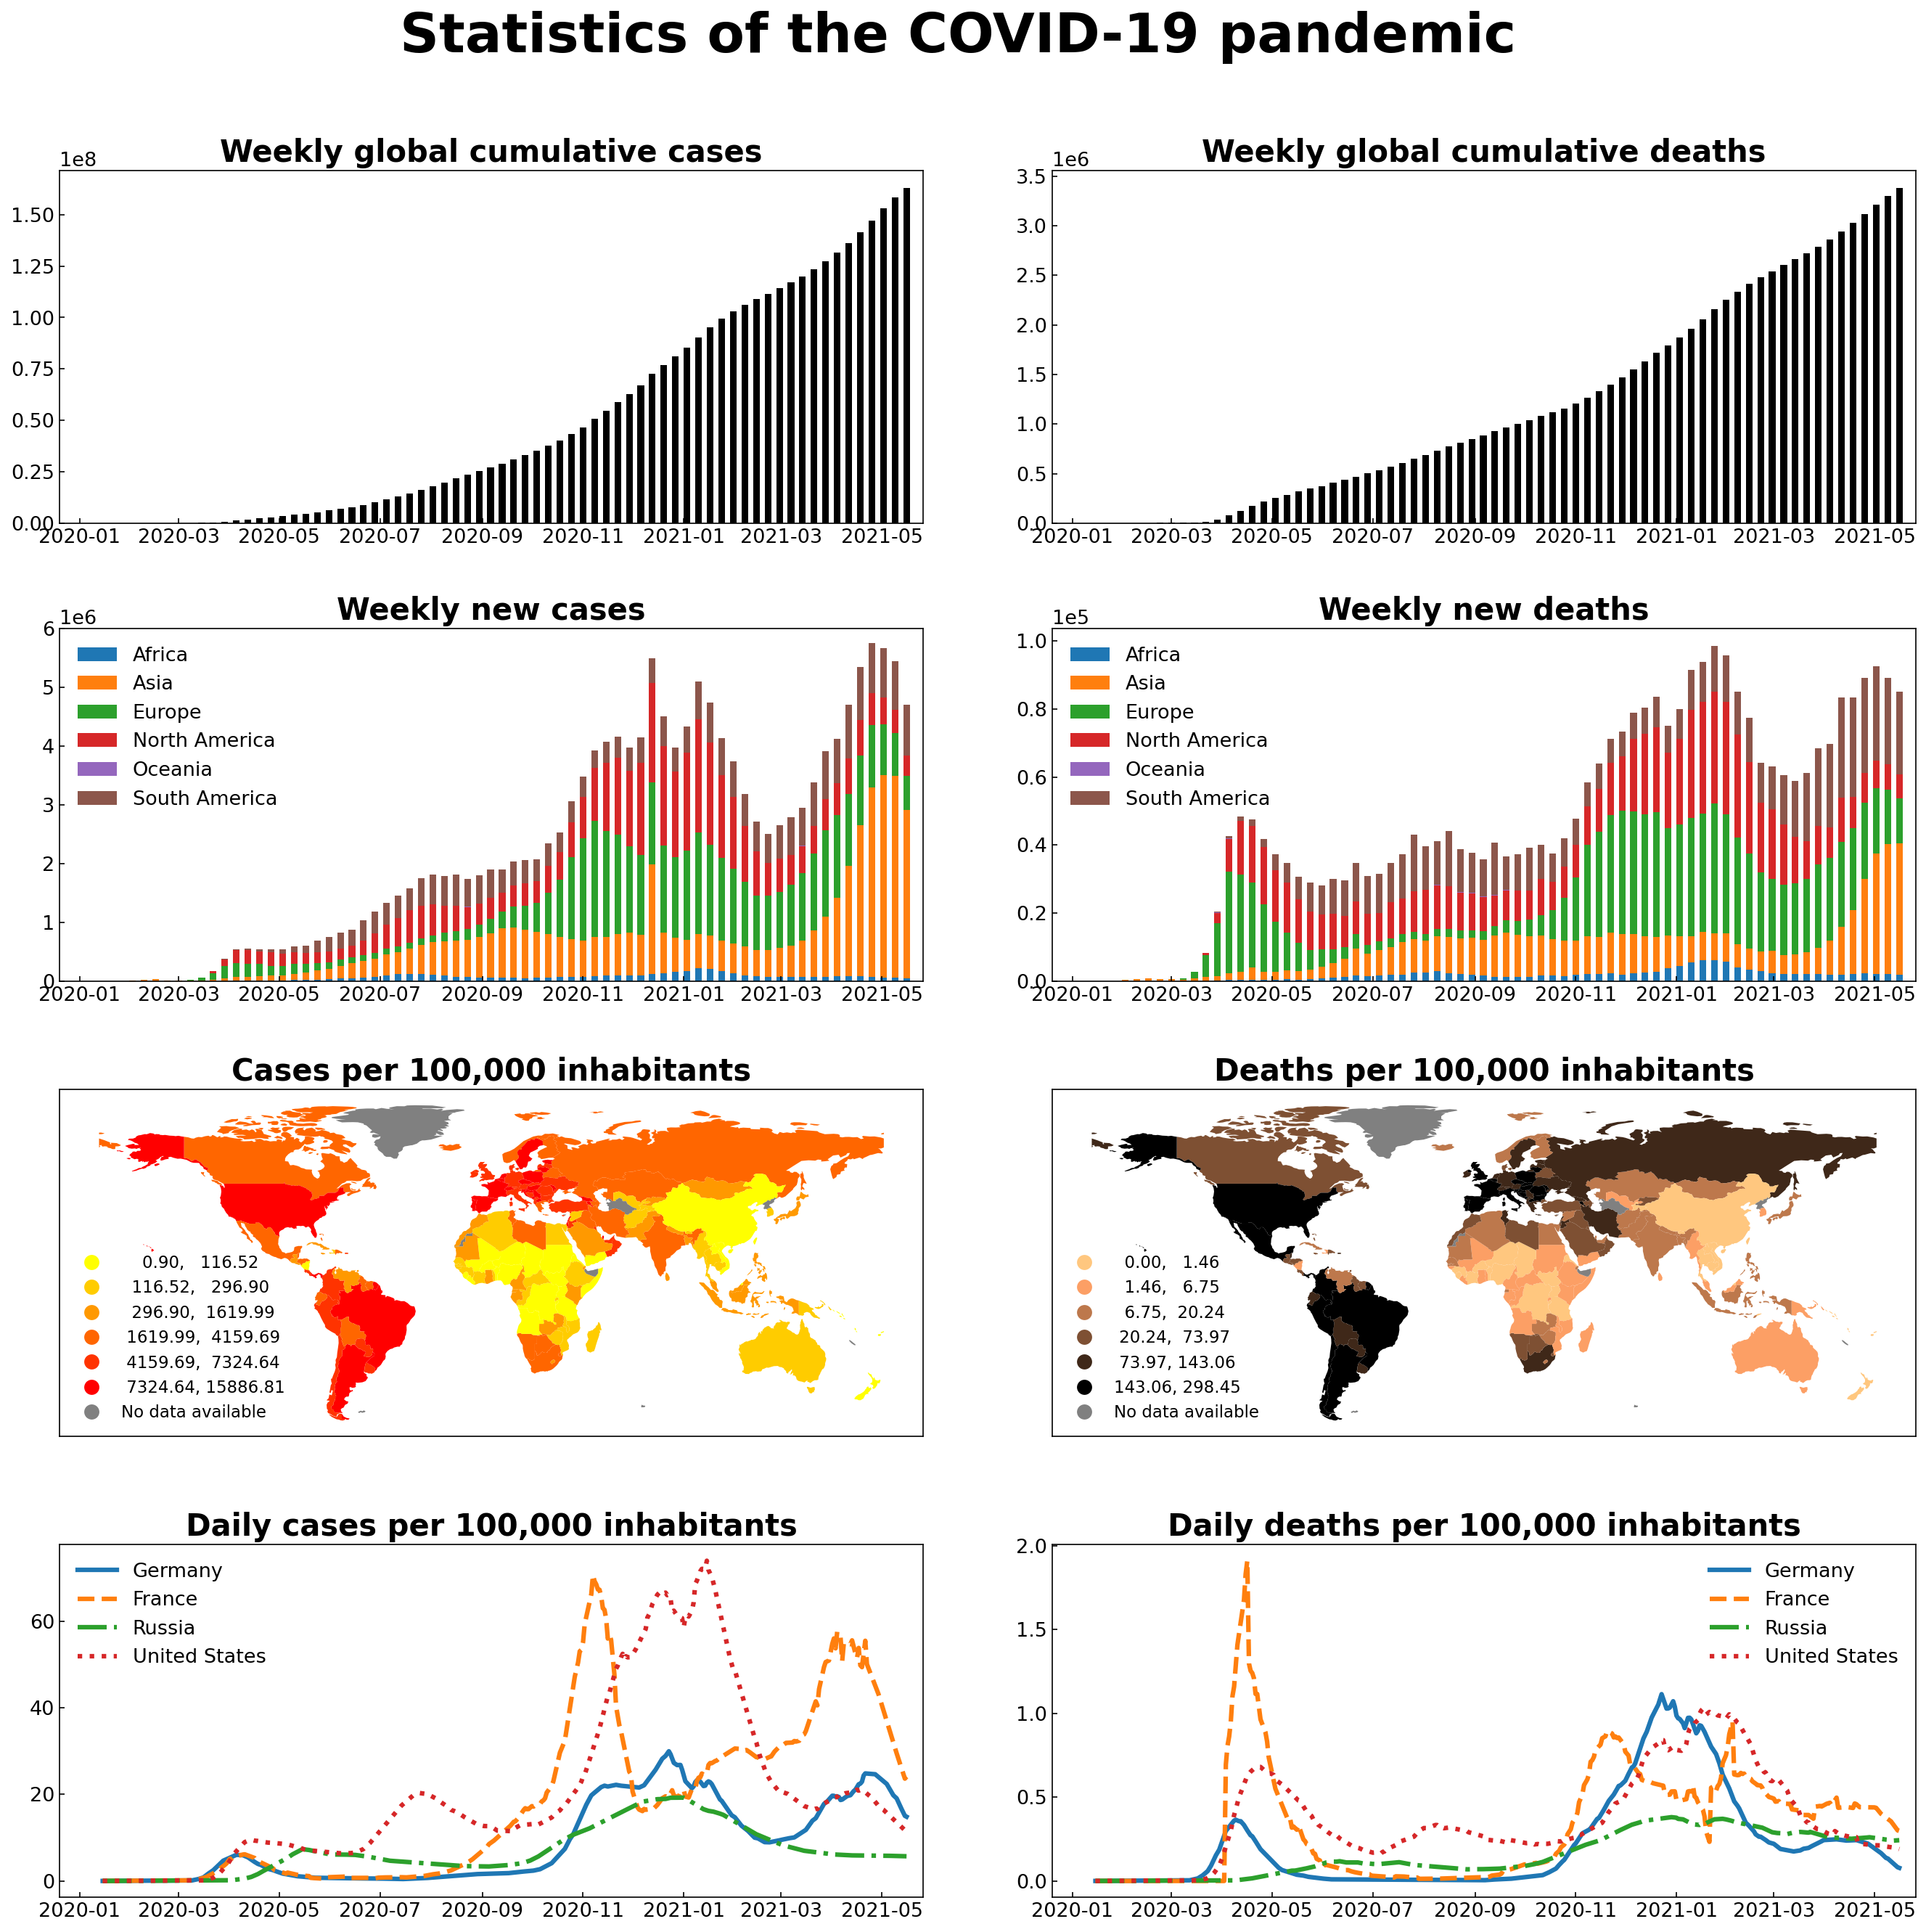

In [36]:
pathAndFilename = '../output/desc_stats_covid19.png'
fig.savefig(pathAndFilename, bbox_inches='tight', dpi=150)

Image(filename=pathAndFilename) 

Intrestingly, I find that there are great differences in cases across countries and that a heavy Covid19 outbreak is not necessarily determined by geographical location, hence other reasons might affect the spread of the disease. In order to further explore the distribution of Covid-19 cases, I will run descriptive statistics for some variables of interest.

<a id="descriptive_statistics"></a>
### Descriptive statistics

**New cases by continent**

This is the distribution of weekly new cases grouped by continent.

Text(0.5, 0, 'Normalized z-score')

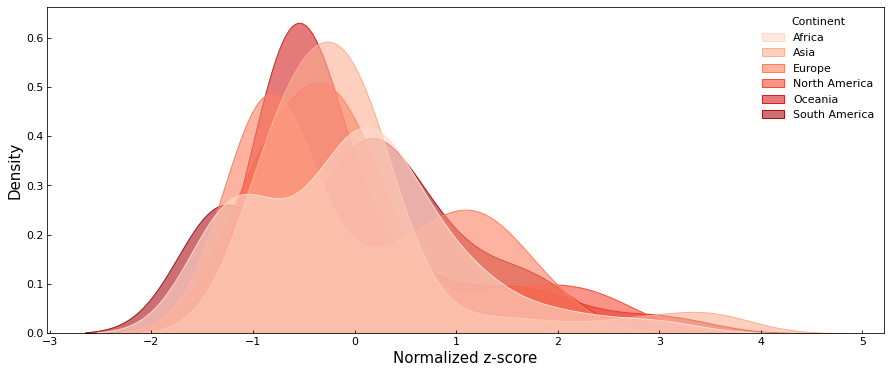

In [37]:
fig, ax = plt.subplots(figsize=(15,6))

sns.kdeplot(
   data=pd.melt(casesPerContinent.apply(lambda x: (x - x.mean()) / x.std(), axis=0).reset_index(), id_vars='date', value_vars=casesPerContinent.columns).rename(columns={'value':'Normalized z-score', 'continent': 'Continent'}), x="Normalized z-score", hue="Continent",
   fill=True, common_norm=False, palette="Reds",
   alpha=.6, linewidth=1);

ax.set_ylabel('Density', fontsize=15)
ax.set_xlabel('Normalized z-score', fontsize=15)

A descriptive table is shown below.

In [38]:
casesPerContinent.columns.name = 'Continent'
casesPerContinent.describe().T.rename(columns={'count':'Count', 'mean':'Mean','std':'Std', 'min':'Min', 'max':'Max'}).style.background_gradient(axis=0, cmap='Reds').set_precision(1)

,Count,Mean,Std,Min,25%,50%,75%,Max
Continent,,,,,,,,
Africa,72.0,64490.8,51132.4,0.0,16829.5,66278.5,90804.5,221966.0
Asia,72.0,647199.3,784444.5,1.0,98349.0,524992.5,697782.0,3442898.0
Europe,72.0,640709.9,620134.4,0.0,110020.5,267077.5,1232159.5,1982464.0
North America,72.0,535071.9,498825.0,0.0,198977.5,425887.0,590199.5,1927731.0
Oceania,72.0,646.2,888.6,0.0,97.5,176.5,938.0,3574.0
South America,72.0,371906.6,270081.2,0.0,92555.0,380415.5,513418.0,911723.0


While Asia records the highest mean in weekly new cases, it also has the highest standard deviation. Distributions are universally right-skewed indicating that there are rare weeks, where the number of new cases are extremely high.

**Deaths by continent**

Text(0.5, 0, 'Normalized z-score')

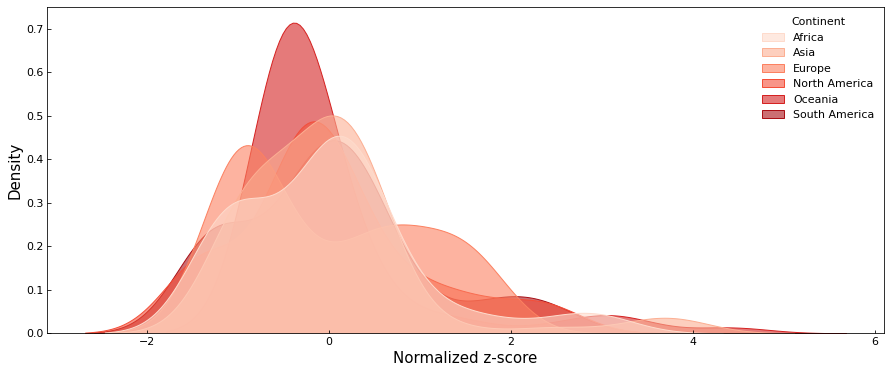

In [39]:
fig, ax = plt.subplots(figsize=(15,6))

sns.kdeplot(
   data=pd.melt(deathsPerContinent.apply(lambda x: (x - x.mean()) / x.std(), axis=0).reset_index(), id_vars='date', value_vars=deathsPerContinent.columns).rename(columns={'value':'Normalized z-score', 'continent': 'Continent'}), x="Normalized z-score", hue="Continent",
   fill=True, common_norm=False, palette="Reds",
   alpha=.6, linewidth=1);

ax.set_ylabel('Density', fontsize=15)
ax.set_xlabel('Normalized z-score', fontsize=15)

In [40]:
deathsPerContinent.columns.name = 'Continent'
deathsPerContinent.describe().T.rename(columns={'count':'Count', 'mean':'Mean','std':'Std', 'min':'Min', 'max':'Max'}).style.background_gradient(axis=0, cmap='Reds').set_precision(1)

,Count,Mean,Std,Min,25%,50%,75%,Max
Continent,,,,,,,,
Africa,72.0,1747.7,1471.6,0.0,442.0,1806.5,2248.5,6242.0
Asia,72.0,8420.5,7868.8,0.0,2650.2,7911.0,10713.2,38619.0
Europe,72.0,14605.3,13008.8,0.0,2446.8,11814.5,24942.2,38070.0
North America,72.0,12032.9,8571.3,0.0,8475.8,10629.0,15385.0,33056.0
Oceania,72.0,15.0,29.3,0.0,0.0,2.0,15.2,144.0
South America,72.0,10142.5,7779.4,0.0,5324.5,10117.0,12970.2,29419.0


Similar patterns can be found for fatal cases, as death cases are preceeded by a previous infection. Observable is a much higher mean for Europe, whereby Oceania still inherits the least cases.

**Death-to-case-ratio**

An interesting metric that we could have a look at is the ratio between the average weekly deaths as percentage to the average weekly cases. I name this measure the death-to-case ratio.

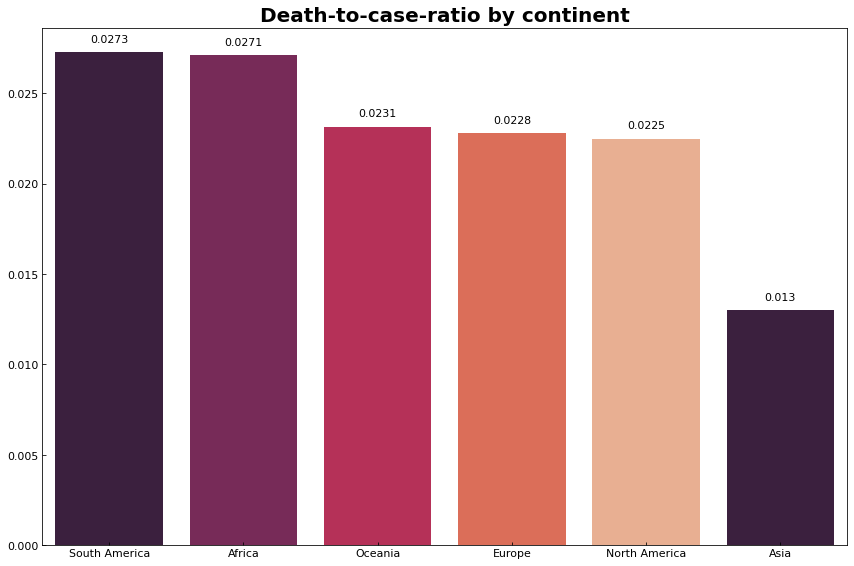

In [148]:
fig, ax = plt.subplots(figsize=(12,8))

data = (deathsPerContinent.describe().T['mean'] / casesPerContinent.describe().T['mean']).to_frame(name = 'Death-to-case-ratio').reset_index().sort_values(by='Death-to-case-ratio', ascending=False)
sns.barplot(data=data, y='Death-to-case-ratio', x='Continent', palette=sns.color_palette('rocket', 5))

ax.set_title(f"Death-to-case-ratio by continent", size=20, fontweight='bold')
ax.set_ylabel(None)
ax.set_xlabel(None)
for i, p in enumerate(sorted([x for x in ax.patches if not pd.isna(x.get_height())], key=lambda k: k.get_height(), reverse=True)):
    name = round(data['Death-to-case-ratio'].iloc[i], ndigits=4)
    ax.annotate(name, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center' , va='baseline', xytext=(0, 10), textcoords='offset points')
    
fig.tight_layout()

The barplot indicates that South America experiences the greatest death-to-case ratio while Asia records the lowest value.

**New cases by country**

Let's compare cases across countries.

In [125]:
countryList = ['DEU', 'FRA', 'RUS', 'USA']
linestyleList = ['-', '--', '-.', ':']

Text(0.5, 0, 'Normalized z-score')

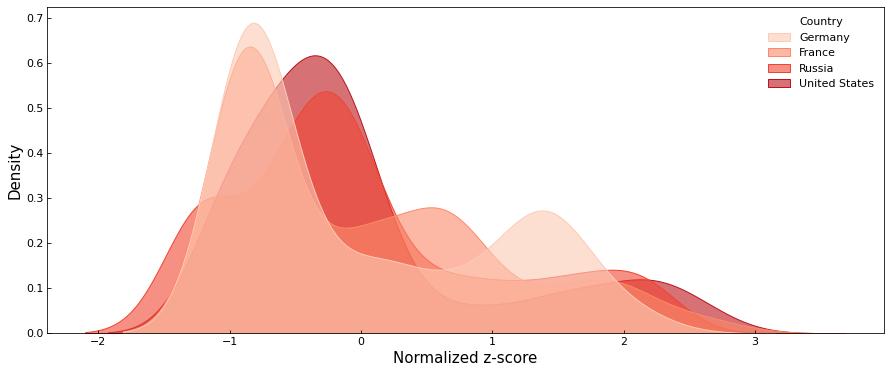

In [130]:
df = cleanCovidData.loc[cleanCovidData.index.get_level_values('country').isin(countryList)]
df['casesMovAvg'] = (df['dailyNewCases'] / df['population'] * 100000).rolling(window=14).mean()
casesPerCountry = df[['casesMovAvg']].reset_index().pivot(columns='country', index='date', values='casesMovAvg').rename(columns={'DEU':'Germany', 'FRA':'France', 'RUS':'Russia', 'USA': 'United States'})

fig, ax = plt.subplots(figsize=(15,6))

sns.kdeplot(
   data=pd.melt(casesPerCountry.apply(lambda x: (x - x.mean()) / x.std(), axis=0).reset_index(), id_vars='date', 
                value_vars=casesPerCountry.columns).rename(columns={'value':'Normalized z-score', 'country': 'Country'}), x="Normalized z-score", hue="Country",
   fill=True, common_norm=False, palette="Reds",
   alpha=.6, linewidth=1);

ax.set_ylabel('Density', fontsize=15)
ax.set_xlabel('Normalized z-score', fontsize=15)

In [131]:
desc = casesPerCountry.describe().T.rename(columns={'count':'Count', 'mean':'Mean','std':'Std', 'min':'Min', 'max':'Max'})
desc.index = ['Germany', 'France', 'Russia', 'United States']
desc.style.background_gradient(axis=0, cmap='Reds').set_precision(1)

,Count,Mean,Std,Min,25%,50%,75%,Max
Germany,488.0,8.7,9.3,0.0,0.6,3.6,18.5,29.9
France,488.0,17.7,18.8,0.0,1.0,11.5,29.9,70.6
Russia,488.0,6.8,5.6,0.0,3.4,5.9,9.7,19.3
United States,488.0,20.5,19.4,0.0,7.6,15.2,21.0,73.9


If I control for the population of the countries (i.e. I take cases per inhabitants), I can compare countries of different sizes. I find that the geographical location does not necessarily determine the distribution of weekly new cases as can be seen with France and Germany. France and Germany are two countries directly located next each other, however they were hit by the pandemic with different intensities.

**Deaths by country**

For the sake of completeness, I do the same investigation for fatal cases.

Text(0.5, 0, 'Normalized z-score')

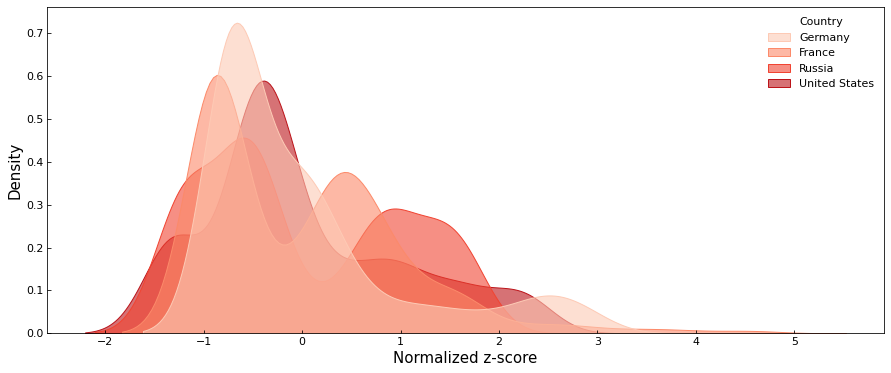

In [132]:
df = cleanCovidData.loc[cleanCovidData.index.get_level_values('country').isin(countryList)]
df['casesMovAvg'] = (df['dailyNewDeaths'] / df['population'] * 100000).rolling(window=14).mean()
deathsPerCountry = df[['casesMovAvg']].reset_index().pivot(columns='country', index='date', values='casesMovAvg').rename(columns={'DEU':'Germany', 'FRA':'France', 'RUS':'Russia', 'USA': 'United States'})

fig, ax = plt.subplots(figsize=(15,6))

sns.kdeplot(
   data=pd.melt(deathsPerCountry.apply(lambda x: (x - x.mean()) / x.std(), axis=0).reset_index(), id_vars='date', 
                value_vars=deathsPerCountry.columns).rename(columns={'value':'Normalized z-score', 'country': 'Country'}), x="Normalized z-score", hue="Country",
   fill=True, common_norm=False, palette="Reds",
   alpha=.6, linewidth=1);

ax.set_ylabel('Density', fontsize=15)
ax.set_xlabel('Normalized z-score', fontsize=15)

In [133]:
desc = deathsPerCountry.describe().T.rename(columns={'count':'Count', 'mean':'Mean','std':'Std', 'min':'Min', 'max':'Max'})
desc.index = ['Germany', 'France', 'Russia', 'United States']
desc.style.background_gradient(axis=0, cmap='Reds').set_precision(1)

,Count,Mean,Std,Min,25%,50%,75%,Max
Germany,488.0,0.2,0.3,0.0,0.0,0.1,0.3,1.1
France,488.0,0.3,0.3,0.0,0.0,0.3,0.5,1.9
Russia,488.0,0.2,0.1,0.0,0.1,0.1,0.3,0.4
United States,488.0,0.4,0.3,0.0,0.2,0.3,0.6,1.0


**Death-to-case-ratio**

Let's calculate the death-to-case-ratio on the country level.

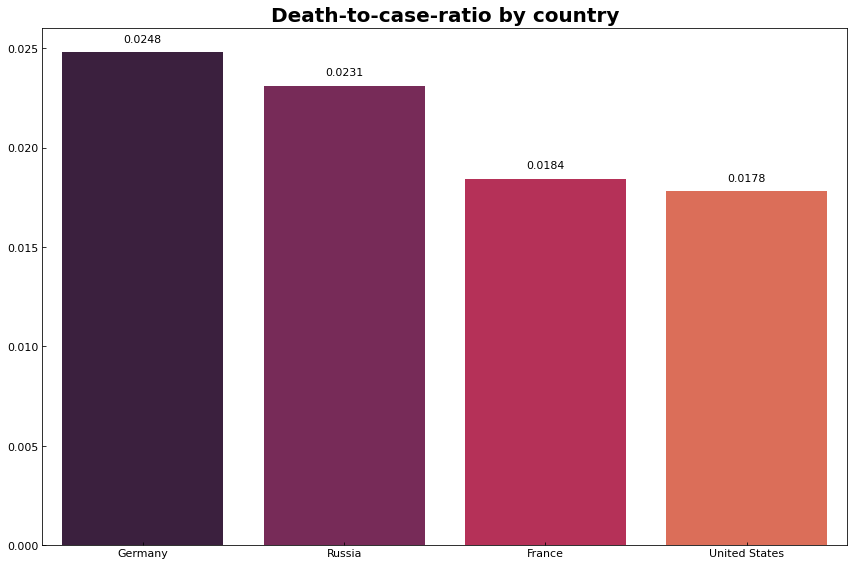

In [153]:
fig, ax = plt.subplots(figsize=(12,8))

data = (deathsPerCountry.describe().T['mean'] / casesPerCountry.describe().T['mean']).to_frame(name = 'Death-to-case-ratio').reset_index().sort_values(by='Death-to-case-ratio', ascending=False)
sns.barplot(data=data, y='Death-to-case-ratio', x='country', palette=sns.color_palette('rocket', 5))

ax.set_title(f"Death-to-case-ratio by country", size=20, fontweight='bold')
ax.set_ylabel(None)
ax.set_xlabel(None)
for i, p in enumerate(sorted([x for x in ax.patches if not pd.isna(x.get_height())], key=lambda k: k.get_height(), reverse=True)):
    name = round(data['Death-to-case-ratio'].iloc[i], ndigits=4)
    ax.annotate(name, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center' , va='baseline', xytext=(0, 10), textcoords='offset points')
    
fig.tight_layout()

The barplot indicates that Germany shows the greatest death-to-case-ratio while the United States records the lowest. In summary, the visualizations presented in this section have shown, that geographical location does not necessarily determine the distribution neither of Covid-19 cases nor of deaths, hence there must be other variables maybe associated to the institutional system that might facilitate or dampen the spread of the Covid-19 pandemic.

<a id="sirf_model_parameter_estimation_and_visualization"></a>
## SIRF model parameter estimation and visualization

In this section, the parameters of the SIRF model will be estimated by using historical data.

<a id="parameter_estimation"></a>
### Parameter estimation

**Data import**

In [46]:
dataLoader = cs.DataLoader("input")
jhuData = dataLoader.jhu(verbose=0)
populationData = dataLoader.population()
oxcgrtData = dataLoader.oxcgrt()

df = jhuData.raw.drop_duplicates('Country')
countriesDict = dict(zip(df['ISO3'], df['Country']))

Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan


**Hyperparameter estimation**  
A two step hyperparameter estimation will be deployed. In a first run, parameters will be estimated over the whole time series of available data. In a second run, the largest increase in government stringency will be identified and parameters will be estimated until this point in time. This approach allows comparisons which are central to this analysis. First, it is possible to compare parameter values before impositions of stringent government measures with the parameter values that persist to the current point in time. Second and most importantly, it allows to analyse the efficacy of government measures from a retrospective point of view. As parameter values will be trained on data before governmental interventions, it allows to evaluate the effective impact of imposed measures on the models parameters and whether those measures were successfully enforced by the government. NOTE: The following cell has already been run for 72 hours and estimation result were stored in the folder 'retrospective'.

In [ ]:
# Do not run this as this takes time, results are stored in the folder 'retrospective'
# Defining the directory to store the estimated parameters
backupfileDict = cs.Filer(directory='retrospective')

files = [x[:3] for x in os.listdir('retrospective')]

for iCountry in tqdm(countriesDict):
    
    if iCountry not in files:
        
        try:
            
            # Instantiation of the country object.
            exec(f'{iCountry} = cs.Scenario(country="{countriesDict[iCountry]}")')
            eval(iCountry).register(jhuData, extras=[oxcgrtData])

            # S-R relationship analysis
            eval(iCountry).trend(show_figure = False)

            # Minimum of 90 days for parameter estimation.
            df = eval(iCountry).records(variables='all', show_figure=False).tail(-90)

            # Identification of largest stringency increase.
            iMax = np.argmax(np.diff(df['Stringency_index']))
            date = df.iloc[iMax, :]['Date']
            row = eval(iCountry).summary()[eval(iCountry).summary().apply(lambda k: datetime.strptime(k[1],'%d%b%Y') <= date <= datetime.strptime(k[2],'%d%b%Y'), axis=1)]
            beginningDate = row['End'][0]

            # Parameter estimation
            eval(iCountry).retrospective(beginning_date=beginningDate, model=cs.SIRF, control="Main", target="Retrospective", timeout=180)
            
            # JSON serialization
            eval(iCountry).backup(**backupfileDict.json(f'{iCountry}'))

        except:
            
            continue

<a id="data_inspection"></a>
### Data inspection

After having computed the model parameters for each country, we can have a first look at the estimation results which will give us a first intuition of how the target variables may be distributed.

**Loading estimations**

In [47]:
# You have to run this
# Import of parameter estimations
retrospective = {}

for iFile in tqdm(os.listdir('../data/retrospective')):
    
    if iFile.endswith('json'):
        
        country = iFile[:3]
        
        try:
            
            exec(f'{country} = cs.Scenario(country="{countriesDict[country]}")')
            eval(country).register(jhuData, extras=[oxcgrtData])
            eval(country).restore(f'../data/retrospective/{country}.json')
            
            continent = pc.country_alpha2_to_continent_code(pyc.countries.get(alpha_3=country).alpha_2)
            
            dic = retrospective.get(continent, {})
            dic.update({country:eval(country)})
            retrospective[continent] = dic

        except:
            
            continue

100%|██████████| 155/155 [11:53<00:00,  4.60s/it]


**Confirmed cases**  
First, I visualize the confirmed cases.

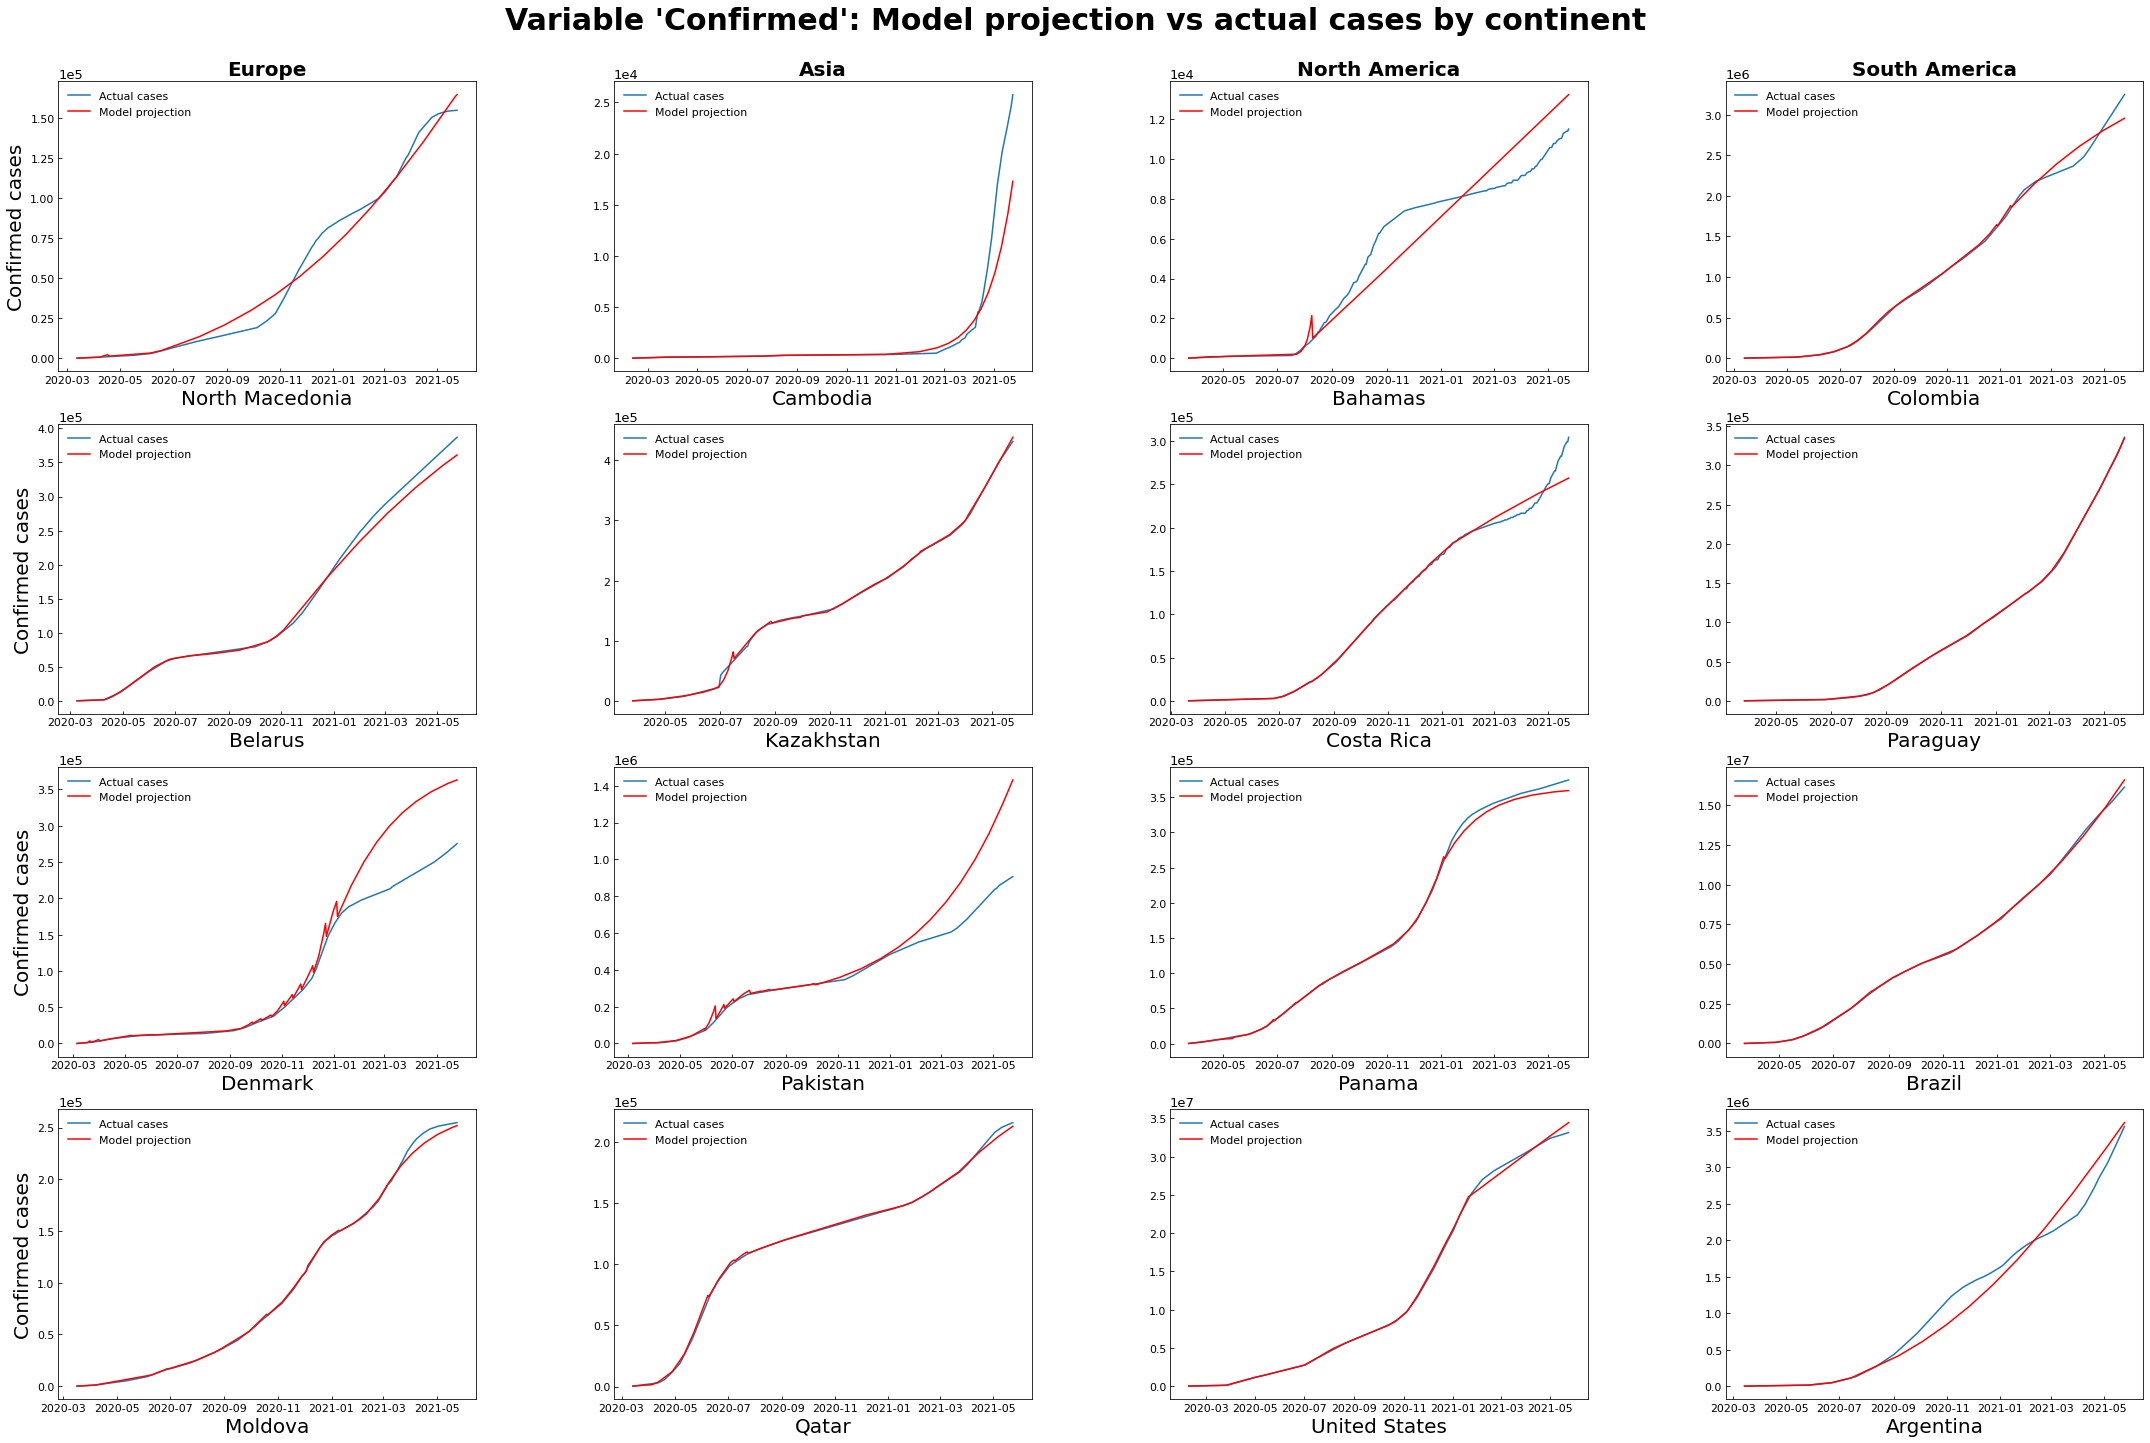

In [48]:
cols = {'EU':'Europe', 'AS':'Asia', 'NA':'North America', 'SA':'South America'}
rows = ['Confirmed cases'] * 4

fig, axes = plt.subplots(4, 4, figsize=(30,20))

for iIteration, iCol in enumerate(cols):

    for jIteration, iCountry in enumerate(random.sample(retrospective[iCol].keys(), 4)):
        
        df = eval(iCountry).history('Confirmed', show_figure=False).reset_index()
        sns.lineplot(data=df, x='Date', y='Actual', ax=axes[jIteration][iIteration], label='Actual cases')
        sns.lineplot(data=df, x='Date', y='Retrospective', ax=axes[jIteration][iIteration], label='Model projection', color='red')
        axes[jIteration][iIteration].set_ylabel(None)
        axes[jIteration][iIteration].set_xlabel(countriesDict[iCountry], fontsize=20)
        axes[jIteration][iIteration].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        exponent = axes[jIteration][iIteration].yaxis.get_offset_text()
        exponent.set_size(13)

for iAx, iCol in zip(axes[0], cols):
    iAx.set_title(cols[iCol], {'weight': 'bold', 'fontsize':20})

for iAx, iRow in zip(axes[:,0], rows):
    iAx.set_ylabel(iRow, rotation=90, fontsize = 20)

fig.suptitle("Variable 'Confirmed': Model projection vs actual cases by continent", size=30, y=1.001, fontweight='bold')
fig.tight_layout(h_pad=0.3, w_pad=10)
plt.show()

**Fatal cases**  
Next, I plot the deadly cases.

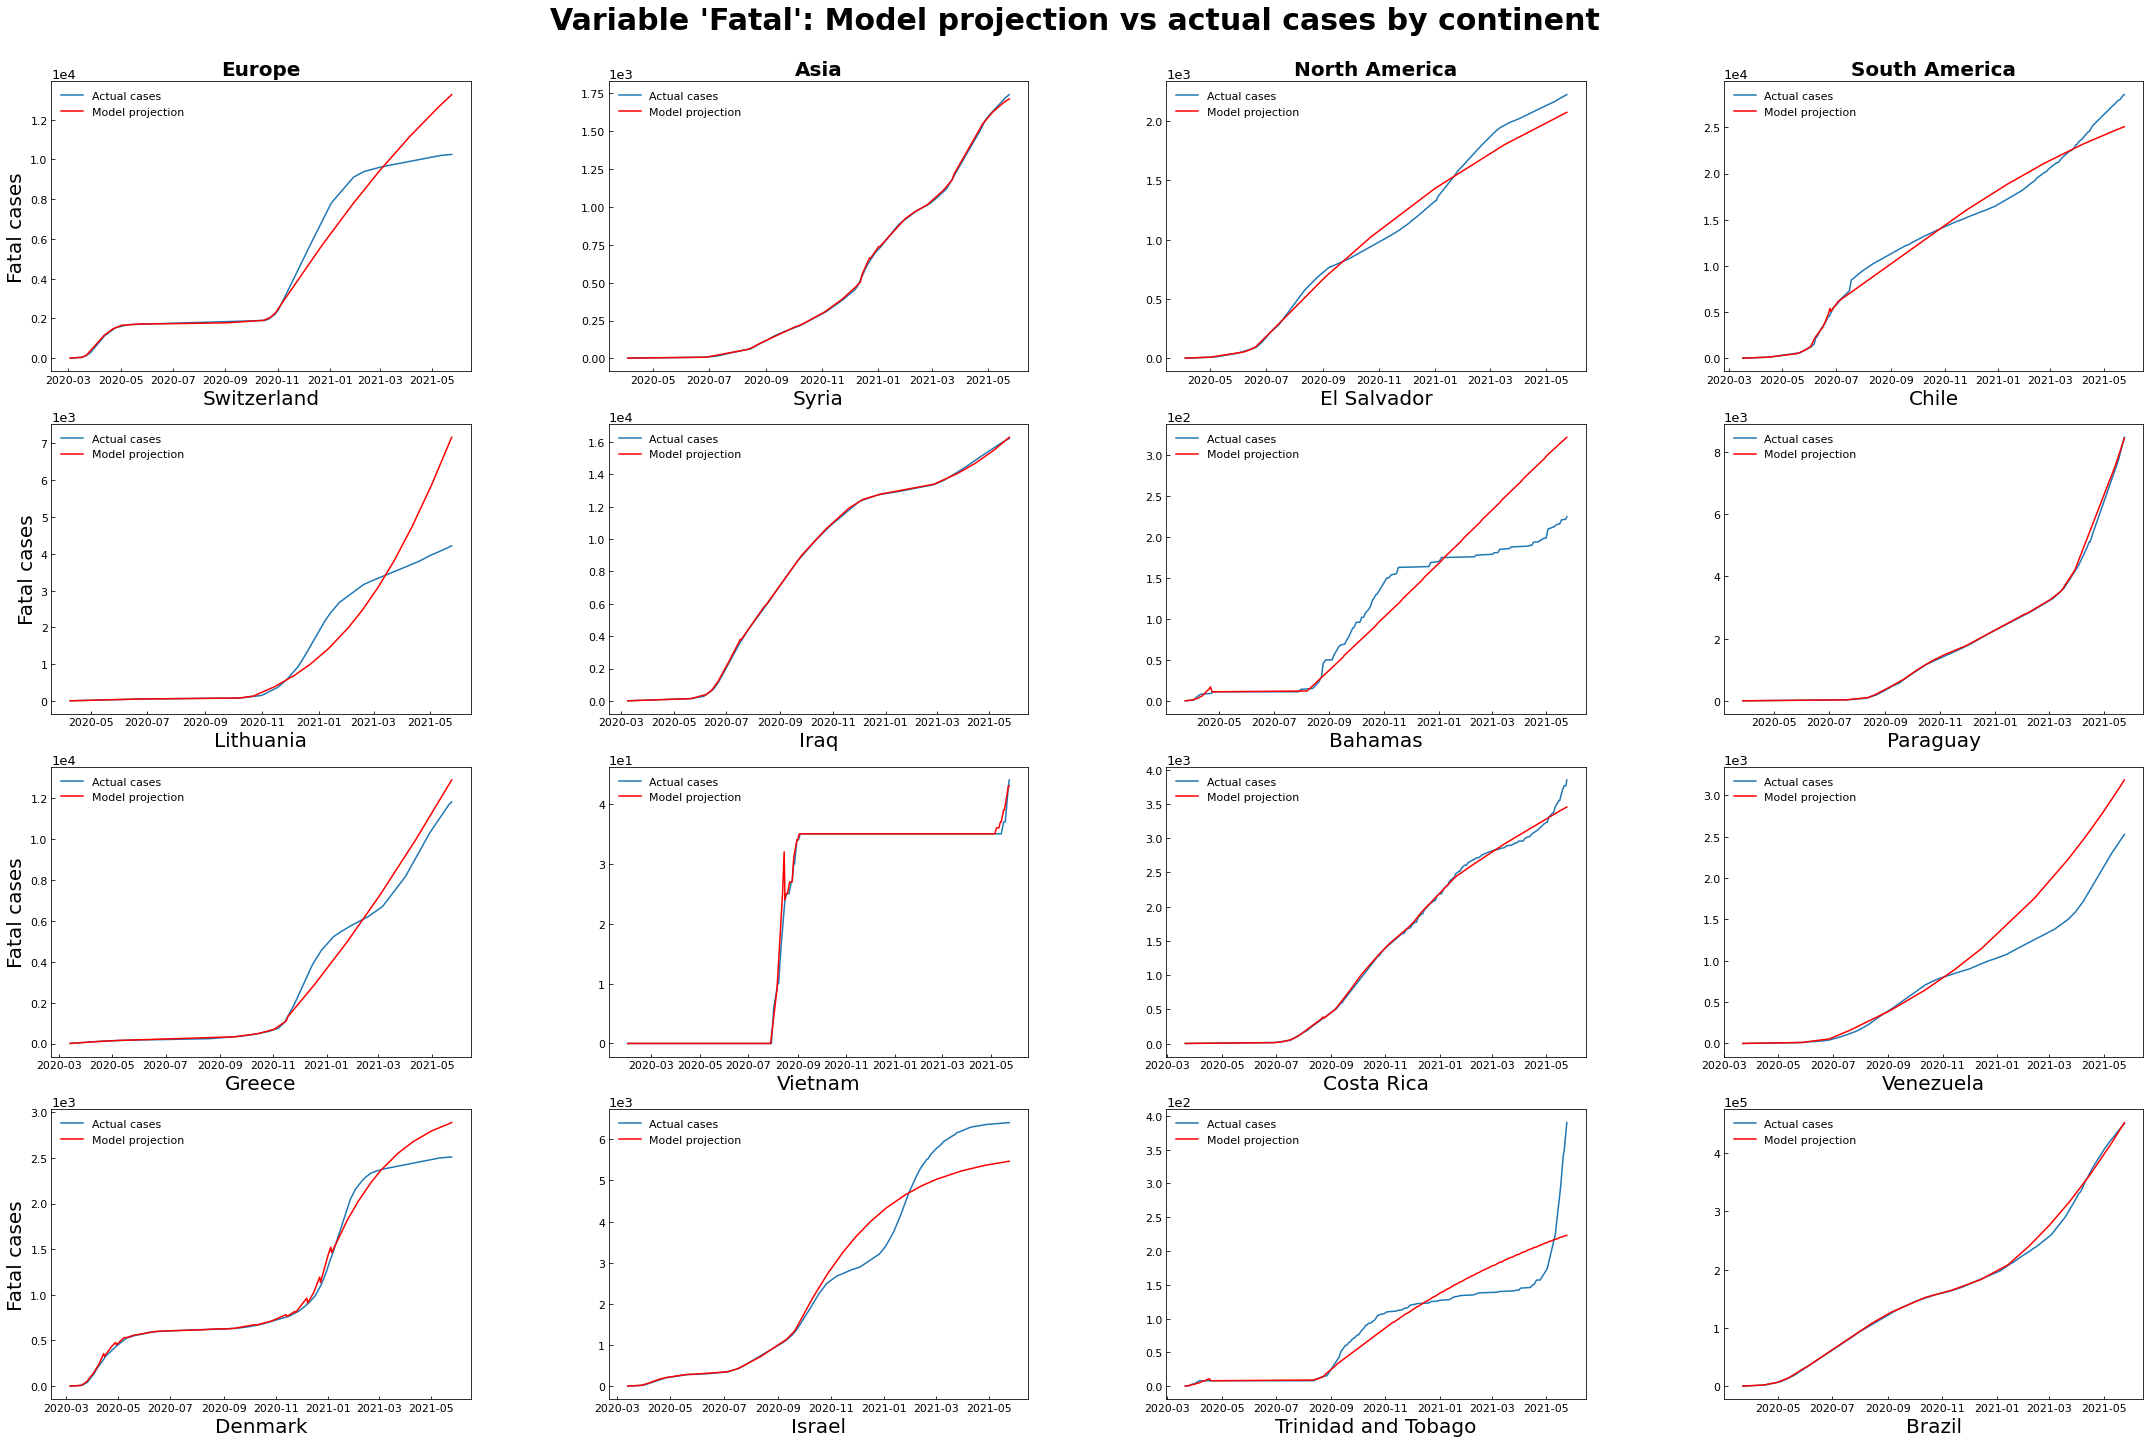

In [49]:
cols = {'EU':'Europe', 'AS':'Asia', 'NA':'North America', 'SA':'South America'}
rows = ['Fatal cases'] * 4

fig, axes = plt.subplots(4, 4, figsize=(30,20))

for iIteration, iCol in enumerate(cols):

    for jIteration, iCountry in enumerate(random.sample(retrospective[iCol].keys(), 4)):
        
        df = eval(iCountry).history('Fatal', show_figure=False).reset_index()
        sns.lineplot(data=df, x='Date', y='Actual', ax=axes[jIteration][iIteration], label='Actual cases')
        sns.lineplot(data=df, x='Date', y='Retrospective', ax=axes[jIteration][iIteration], label='Model projection', color='red')
        axes[jIteration][iIteration].set_ylabel(None)
        axes[jIteration][iIteration].set_xlabel(countriesDict[iCountry], fontsize=20)
        axes[jIteration][iIteration].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        exponent = axes[jIteration][iIteration].yaxis.get_offset_text()
        exponent.set_size(13)

for iAx, iCol in zip(axes[0], cols):
    iAx.set_title(cols[iCol], {'weight': 'bold', 'fontsize':20})

for iAx, iRow in zip(axes[:,0], rows):
    iAx.set_ylabel(iRow, rotation=90, fontsize = 20)

fig.suptitle("Variable 'Fatal': Model projection vs actual cases by continent", size=30, y=1.001, fontweight='bold')
fig.tight_layout(h_pad=0.3, w_pad=10)
plt.show()

**Recovered cases**  
Finally, I investigate the recovered cases.

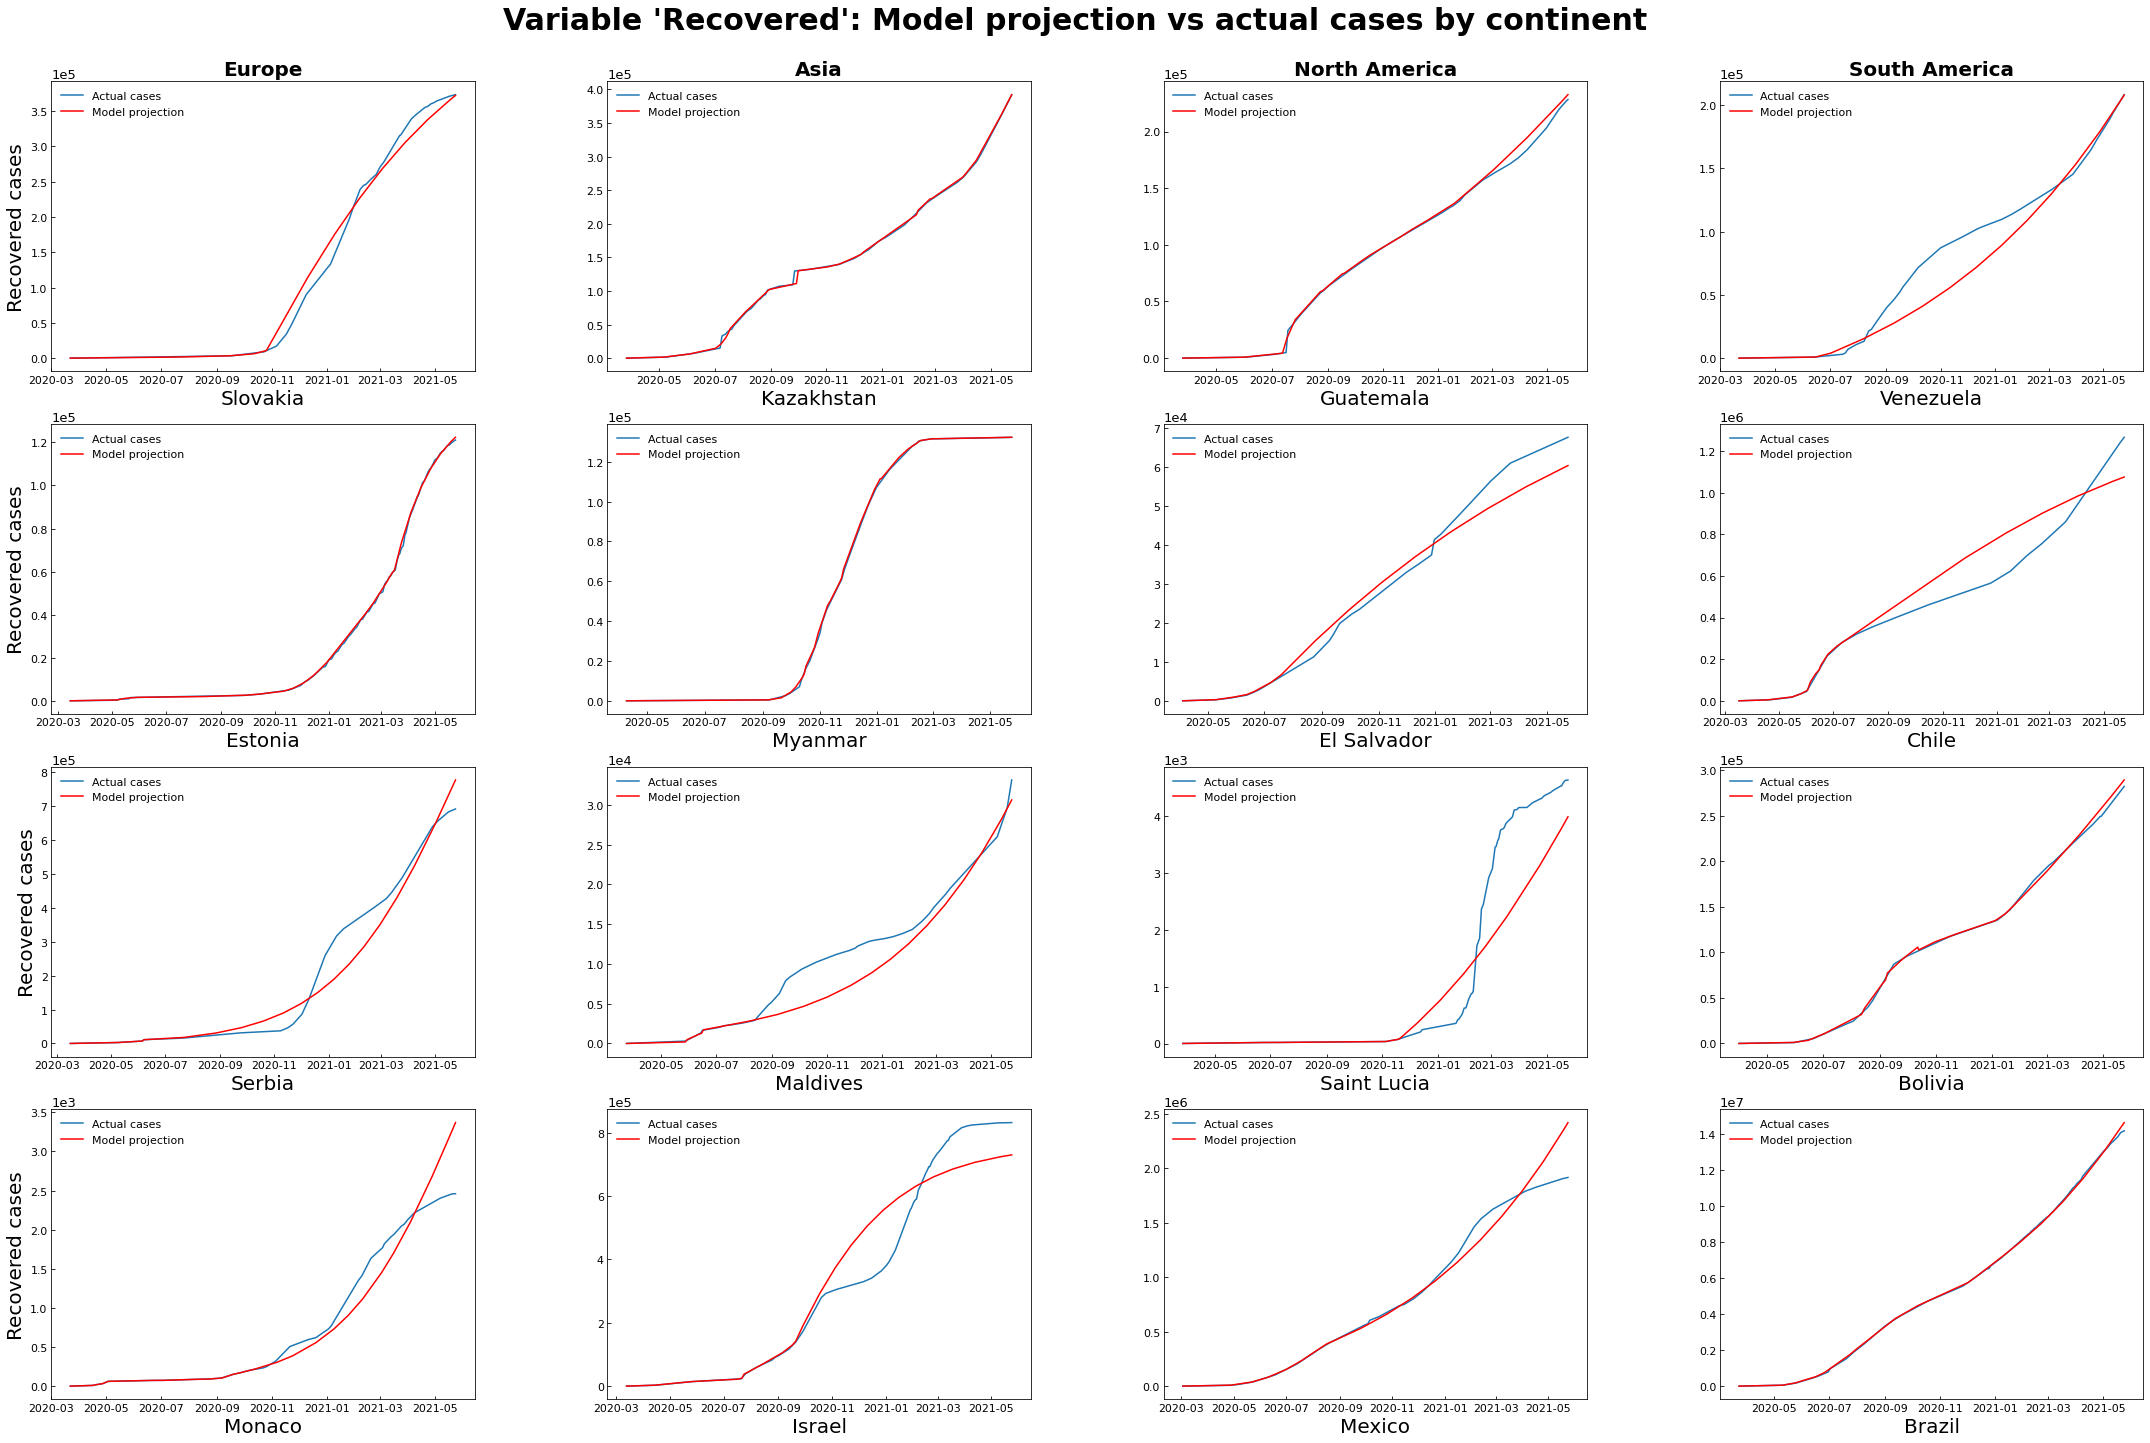

In [50]:
cols = {'EU':'Europe', 'AS':'Asia', 'NA':'North America', 'SA':'South America'}
rows = ['Recovered cases'] * 4

fig, axes = plt.subplots(4, 4, figsize=(30,20))

for iIteration, iCol in enumerate(cols):

    for jIteration, iCountry in enumerate(random.sample(retrospective[iCol].keys(), 4)):
        
        df = eval(iCountry).history('Recovered', show_figure=False).reset_index()
        sns.lineplot(data=df, x='Date', y='Actual', ax=axes[jIteration][iIteration], label='Actual cases')
        sns.lineplot(data=df, x='Date', y='Retrospective', ax=axes[jIteration][iIteration], label='Model projection', color='red')
        axes[jIteration][iIteration].set_ylabel(None)
        axes[jIteration][iIteration].set_xlabel(countriesDict[iCountry], fontsize=20)
        axes[jIteration][iIteration].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        exponent = axes[jIteration][iIteration].yaxis.get_offset_text()
        exponent.set_size(13)

for iAx, iCol in zip(axes[0], cols):
    iAx.set_title(cols[iCol], {'weight': 'bold', 'fontsize':20})

for iAx, iRow in zip(axes[:,0], rows):
    iAx.set_ylabel(iRow, rotation=90, fontsize = 20)

fig.suptitle("Variable 'Recovered': Model projection vs actual cases by continent", size=30, y=1.001, fontweight='bold')
fig.tight_layout(h_pad=0.3, w_pad=10)
plt.show()

**Plausibility of parameter estimation**  
In order to check the plausibility of the estimated parameters, I choose one specific country and see whether the parameters yielded by the optimization algorithm seems reasonable. I illustrate this investigation for the country of Spain. First, I plot the model's variables for actual and predicted cases.

Text(0.5, 1.025, 'Spain')

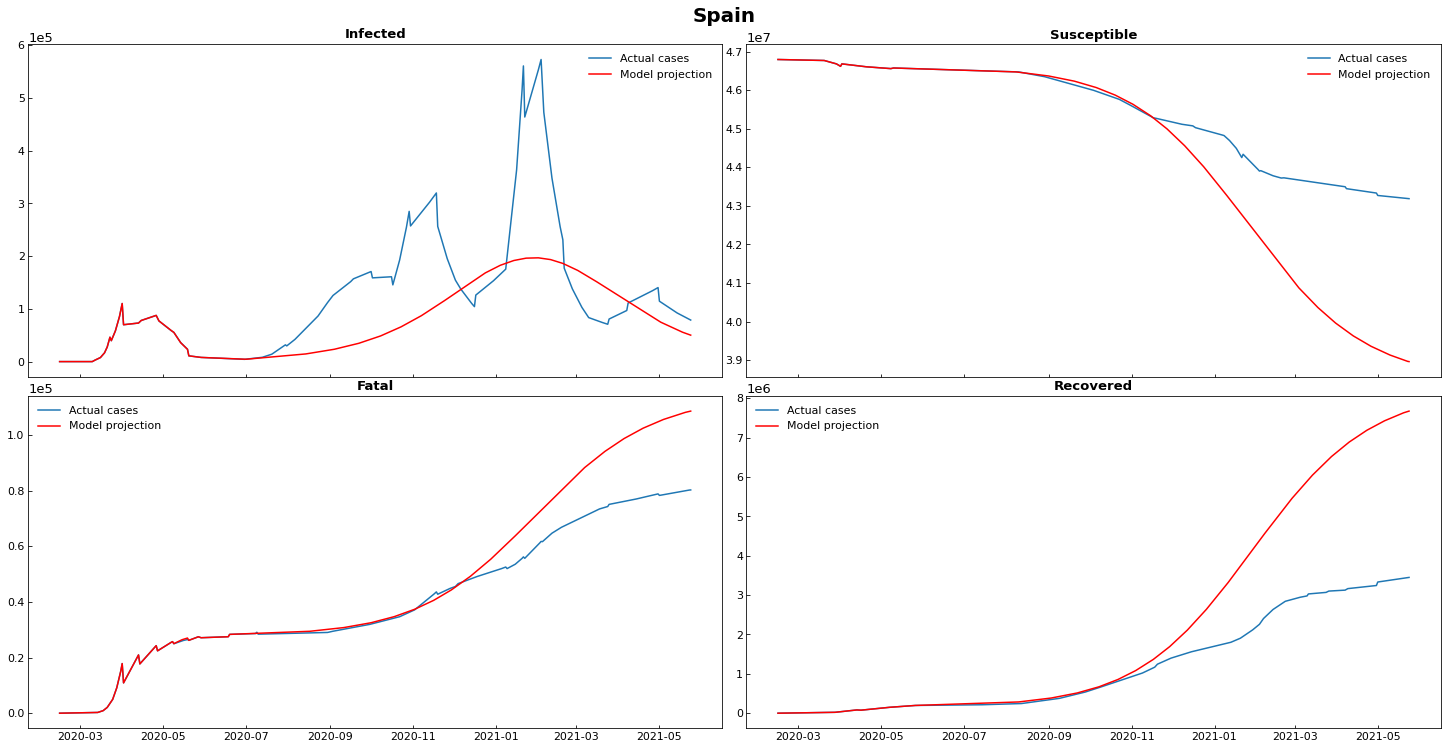

In [51]:
variables = ['Infected', 'Susceptible', 'Fatal', 'Recovered']
fig, axes = plt.subplots(2, 2, figsize=(20,10), sharex=True)
axes = axes.flat

for iIteration, iVar in enumerate(variables):

    df = eval('ESP').history(iVar, show_figure=False, ).reset_index()
    sns.lineplot(data=df, x='Date', y='Main', ax=axes[iIteration], label='Actual cases')
    sns.lineplot(data=df, x='Date', y='Retrospective', ax=axes[iIteration], label='Model projection', color='red')
    axes[iIteration].set_ylabel(None)
    axes[iIteration].set_xlabel(None)
    axes[iIteration].set_title(iVar, fontweight='bold')
    axes[iIteration].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    exponent = axes[iIteration].yaxis.get_offset_text()
    exponent.set_size(13)
    
fig.tight_layout(pad=0.3)
fig.suptitle('Spain', fontweight='bold', y=1.025, fontsize=20)

I observe that the model predicts higher fatal cases while the infection curve has a lower magnitude. These illustrations deviate from my standard scenario analysis in section [2.3 Parameter variation](#parameter_variation) while proving that the actual data seems to inherit much more complex mechanics in the model parameters than only single changes in parameters. I have to realize that in order to understand the differences between model prediction and actual cases, I have to control the parameters by hand.

In [52]:
ESP.summary().reset_index().style.apply(lambda x: ['background: lightgreen' if x['Phase']=='12th'  else '' for i in x], axis=1)

,Scenario,Phase,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
0,Main,0th,Past,15Feb2020,11Mar2020,46796540,SIR-F,8.880000,0.274407,0.007991,0.394632,0.024249,720,0.274000,62.000000,1.000000,20.000000
1,Main,1st,Past,12Mar2020,24Mar2020,46796540,SIR-F,6.230000,0.000595,0.009981,0.152829,0.014517,720,0.001000,50.000000,3.000000,34.000000
2,Main,2nd,Past,25Mar2020,02Apr2020,46796540,SIR-F,2.270000,0.000009,0.012615,0.114539,0.037873,720,0.000000,39.000000,4.000000,13.000000
3,Main,3rd,Past,03Apr2020,14Apr2020,46796540,SIR-F,1.060000,0.000095,0.006374,0.040332,0.031797,720,0.000000,78.000000,12.000000,15.000000
4,Main,4th,Past,15Apr2020,27Apr2020,46796540,SIR-F,1.300000,0.000043,0.003318,0.023320,0.014610,720,0.000000,150.000000,21.000000,34.000000
5,Main,5th,Past,28Apr2020,09May2020,46796540,SIR-F,0.560000,0.000326,0.002214,0.019440,0.032220,720,0.000000,225.000000,25.000000,15.000000
6,Main,6th,Past,10May2020,20May2020,46796540,SIR-F,0.170000,0.012182,0.001929,0.008628,0.049267,720,0.012000,259.000000,57.000000,10.000000
7,Main,7th,Past,21May2020,28May2020,46796540,SIR-F,0.600000,0.074181,0.006940,0.040079,0.054427,720,0.074000,72.000000,12.000000,9.000000
8,Main,8th,Past,29May2020,09Jun2020,46796540,SIR-F,0.780000,0.009757,0.000014,0.037254,0.047104,720,0.010000,36047.000000,13.000000,10.000000
9,Main,9th,Past,10Jun2020,19Jun2020,46796540,SIR-F,0.660000,0.079362,0.000025,0.045053,0.063278,720,0.079000,19967.000000,11.000000,7.000000


Phase 12th constitutes the last parameter values for the Retrospective analysis. Hence I want to compare the last row of this scenario and an average value for this and all following phases for the Main scenario (these are the actual cases). I use a median measure for those parameter values such that they are less likely to be biased especially by the first phases of the parameter estimation.

In [53]:
param = pd.DataFrame(columns=['$\\alpha_1$', '$\\alpha_2$', '$\\beta$', '$\\gamma$'])
param.loc['Actual Cases'] = ESP.summary().loc['Main'].iloc[12:][['theta', 'kappa', 'rho', 'sigma']].median().tolist()
param.loc['Model Prediction'] = ESP.summary().loc['Retrospective'].loc['12th'][['theta', 'kappa', 'rho', 'sigma']].tolist()
param.loc['Percentage'] = list(map(lambda k: '+' + str(k) + '%' if k > 100 else str(k) + '%', ((param.loc['Model Prediction'] / param.loc['Actual Cases'] - 1) * 100).round(1)))
param.style.applymap(lambda k: 'color: red' if (type(k) == str and float(k[:-1]) < 100) else ('color: green' if type(k) == str and float(k[:-1]) > 100 else 'color: black')).background_gradient(subset=pd.IndexSlice[['Actual Cases', 'Model Prediction'],:])

,$\alpha_1$,$\alpha_2$,$\beta$,$\gamma$
Actual Cases,0.006507,0.000220,0.033913,0.025822
Model Prediction,0.000105,0.001258,0.131949,0.118244
Percentage,-98.4%,+471.7%,+289.1%,+357.9%


The table shows that if we compare the parameters used for the predictions with the median values of the actual parameters, the model assumes a lower value for the first and higher values for the other parameters. The differences in those parameter values are to a major extent attributable the mechanics of how government interventions map into a change in model parameters. It follows that the resulting difference of the response variable (infected, confirmed, fatal or recovered cases) can be used to determine the efficacy of government interventions.

<a id="effect_of_government_quality_on_efficacy_of_government_intervention"></a>
## Effect of government quality on efficacy of government interventions

This subsection provides the econometric analysis that evaluates the efficacy of government intervention. First, the length of a window is defined over which the analysis will be conducted. Second, the difference between actual cases and simulated cases will be evaluated. Last, the difference will be regressed on variables related to government efficacy.

<a id="dependent_variable"></a>
### Dependent variable

**Calculation of dependent variable**

The efficacy of government measures manifests itself in the actual infection and fatal cases compared to what could have been, if the government did not intervene. For my analysis, I try two different formulas for estimating the dependent variable for the regressions. Both equations are shown below.

$$ \text{Dependent Variable} = \sum_{t=1}^{N}(A_{t} -  P_{t}) $$

$$ \text{Dependent Variable} = \sum_{t=1}^{N}(log_{10}(A_{t} + 1) - log_{10}(P_{t} + 1))^2 $$

whereby:
- $A_t$ is the number of actual cases at time $t$
- $P_t$ is the predicted cases by the model with the estimated parameters in the previous section

**Definition of time window**  
First, I define all possible time windows over which we can compute the difference between the model projection and actual cases.

In [54]:
windows = {str(x): x for x in np.arange(30, 361, 30)}
windows

{'30': 30,
 '60': 60,
 '90': 90,
 '120': 120,
 '150': 150,
 '180': 180,
 '210': 210,
 '240': 240,
 '270': 270,
 '300': 300,
 '330': 330,
 '360': 360}

Second, I have to control for the fact that not all countries can be analyzed over every time window. This is the case because the point of largest stringency index occur at different points in time for different countries. Hence, for some countries the dependent variable cannot be calculated for the longest time windows. In order to control for this issue, I create an analysis dictionary with keys being the time windows and the values being a collection of countries over which the analysis of this time window is feasible.

In [ ]:
# Do not run this as this takes time, results are stored in the folder 'windows'
for iWindow in windows:

    analysis = {}
    
    for iCountry in tqdm(countriesDict):

        try:

            df = eval(iCountry).records(variables='all', show_figure=False).tail(-90)
            iMax = np.argmax(np.diff(df['Stringency_index']))
            date = df.iloc[iMax, :]['Date']
            row = eval(iCountry).summary()[eval(iCountry).summary().apply(lambda k: datetime.strptime(k[1],'%d%b%Y') <= date <= datetime.strptime(k[2],'%d%b%Y'), axis=1)]
            beginningDate = row['End'][0]

            df = eval(iCountry).summary()
            endDate = df.loc['Main'].iloc[-1]['End']

            if (datetime.strptime(endDate, '%d%b%Y') - datetime.strptime(beginningDate, '%d%b%Y')).days >= windows[iWindow]:
                analysis[iCountry] = beginningDate
        except:

            continue

    with open(f'windows/{windows[iWindow]}.txt', 'w') as file:
        json.dump(analysis, file)

Third, I create a collection of datasets for the differences between the variables of interest (confirmed, infected, fatal and recovered cases) and the corresponding model projection.

In [ ]:
# Do not run this as this takes time, results are stored in the folder 'dependentVariable'
for iWindow in windows:

        dependentVariable = {}

        with open(f'windows/{windows[iWindow]}.txt') as file:

            analysis = json.load(file)

        for iCountry in tqdm(analysis):

            dependentVariable[iCountry] = {}

            try:

                beginningDate = datetime.strptime(analysis[iCountry], '%d%b%Y')
                dfConfirmed = eval(iCountry).history(target='Confirmed', show_figure=False)[['Actual', 'Retrospective']].loc[beginningDate:beginningDate+timedelta(days=int(windows[iWindow]))]
                dfInfected = eval(iCountry).history(target='Infected', show_figure=False)[['Actual', 'Retrospective']].loc[beginningDate:beginningDate+timedelta(days=int(windows[iWindow]))]
                dfFatal = eval(iCountry).history(target='Fatal', show_figure=False)[['Actual', 'Retrospective']].loc[beginningDate:beginningDate+timedelta(days=int(windows[iWindow]))]
                dfRecovered = eval(iCountry).history(target='Recovered', show_figure=False)[['Actual', 'Retrospective']].loc[beginningDate:beginningDate+timedelta(days=int(windows[iWindow]))]

                dependentVariable[iCountry]['Confirmed'] = dfConfirmed.to_json(date_format='iso')
                dependentVariable[iCountry]['Infected'] = dfInfected.to_json(date_format='iso')
                dependentVariable[iCountry]['Fatal'] = dfFatal.to_json(date_format='iso')
                dependentVariable[iCountry]['Recovered'] = dfRecovered.to_json(date_format='iso')

            except:
                continue

        with open(f'dependentVariable/{windows[iWindow]}.txt', 'w') as file:
            json.dump(dependentVariable, file)

As I would like ensure the replicability of my regression results, I store my computations in a separate order, which I will re-import in an next step

In [56]:
# You have to run this
# Import of the dependent variables
dependentVariable = {}
for window in windows:
    dependentVariable[window] = {}
    with open(f'dependentVariable/{windows[window]}.txt') as file:
            analysis = json.load(file)
            for iCountry in analysis:
                for iVariable in analysis[iCountry]:
                    analysis[iCountry][iVariable] = pd.DataFrame(json.loads(analysis[iCountry][iVariable]), columns=['Actual', 'Retrospective'])
            dependentVariable[window].update(analysis)

Finally, I create a function which will allow me to switch between different variables, time windows and computation methods quickly. This will greatly simplify my analysis and will allow me to test my results for robustness over alternative configuration.

In [57]:
def dv(method, variable, window):

    indices = []

    exec(f"{variable}_diffs = []")
    exec(f"{variable} = pd.DataFrame()")

    analysis = dependentVariable[window]

    if method == 'log_sum':

        for iCountry in analysis:

            exec(f"{variable}_diff = ((np.log(analysis[iCountry]['{variable}']['Actual'] + 1) - np.log(analysis[iCountry]['{variable}']['Retrospective'] + 1))**2).sum()")
            indices.append(iCountry)
            exec(f"{variable}_diffs.append({variable}_diff)")

    elif method == 'absolute_sum':

        for iCountry in analysis:

            exec(f"{variable}_diff = (analysis[iCountry]['{variable}']['Actual'] - analysis[iCountry]['{variable}']['Retrospective']).sum()")
            indices.append(iCountry)
            exec(f"{variable}_diffs.append({variable}_diff)")

    exec(f"{variable}['Difference'] = {variable}_diffs")
    exec(f"{variable}['Country'] = indices")
    exec(f"{variable}['Continent'] = {variable}['Country'].apply(lambda k: pc.country_alpha2_to_continent_code(pyc.countries.get(alpha_3=k).alpha_2) if pyc.countries.get(alpha_3=k) != None and pyc.countries.get(alpha_3=k).alpha_2 != 'TL' else np.nan).values")
    exec(f"{variable} = {variable}.dropna()")
    exec(f"{variable} = {variable}.set_index(['Continent', 'Country'])")
    exec(f"{variable} = {variable}.sort_index()")
    
    return eval(variable)

**Distributions of the dependent variable**

The creation of the function in the previous section allows me to investigate the distributions of my variables not only for one specific calculation method or time window, but for different configurations of them.

In [58]:
variables = ['Infected', 'Confirmed', 'Fatal', 'Recovered']

**Differences by country**

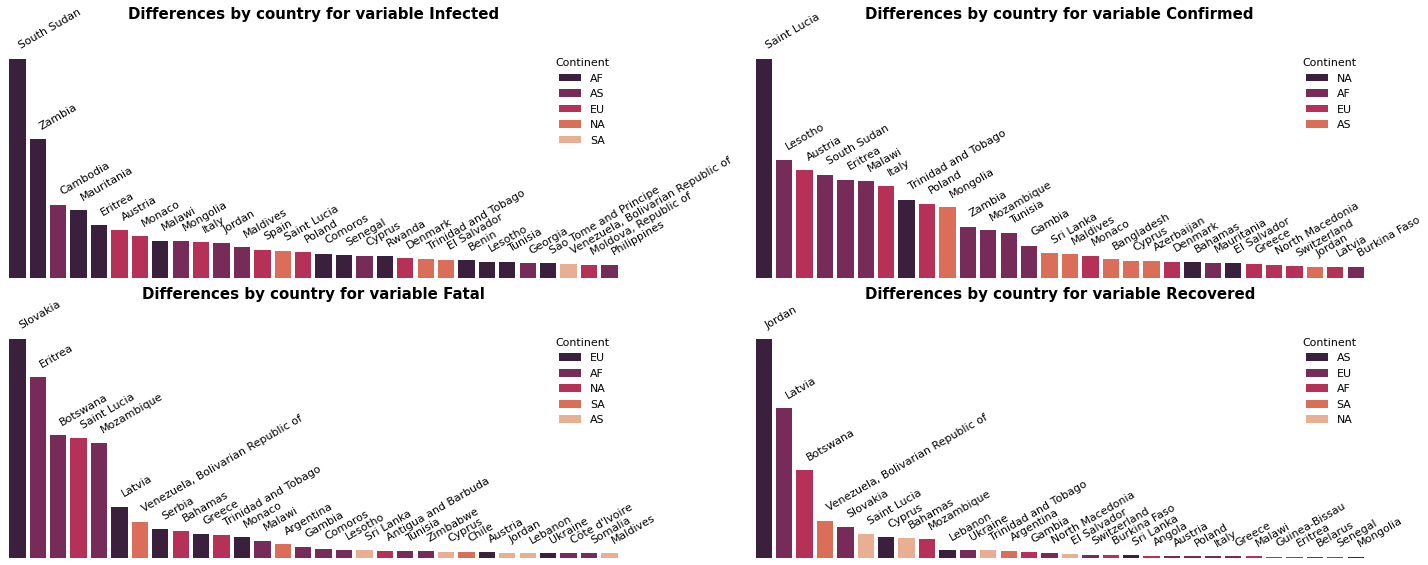

In [59]:
fig, axes = plt.subplots(2,2, figsize=(20,8))

for iIteration, iAx in enumerate(axes.flat):
    data = dv('log_sum', variables[iIteration], '30').reset_index().sort_values('Difference', ascending=False).head(30)
    plot = sns.barplot(data=data, x='Country', y='Difference', hue='Continent', dodge=False, ax=iAx, palette=sns.color_palette('rocket', 5))
    iAx.set_xticklabels('')
    iAx.set_title(f"Differences by country for variable {variables[iIteration]}", size=15, fontweight='bold', y=1.1)
    iAx.set_ylabel('Difference', size=15) 
    iAx.set_xlabel(None)
    for i, p in enumerate(sorted([x for x in iAx.patches if not pd.isna(x.get_height())], key=lambda k: k.get_height(), reverse=True)):
        name = data['Country'].apply(lambda k: pyc.countries.get(alpha_3=k).name).tolist()[i]
        iAx.annotate(name, (p.get_x() + p.get_width() / 2., p.get_height()), ha='left', va='baseline', xytext=(0, 10), textcoords='offset points', rotation=30)
    iAx.axis('off')
    
fig.tight_layout()


The order of the largest differences changes accross variable. Also, some continents appear more often in upper percentiles of the differences than other continents.

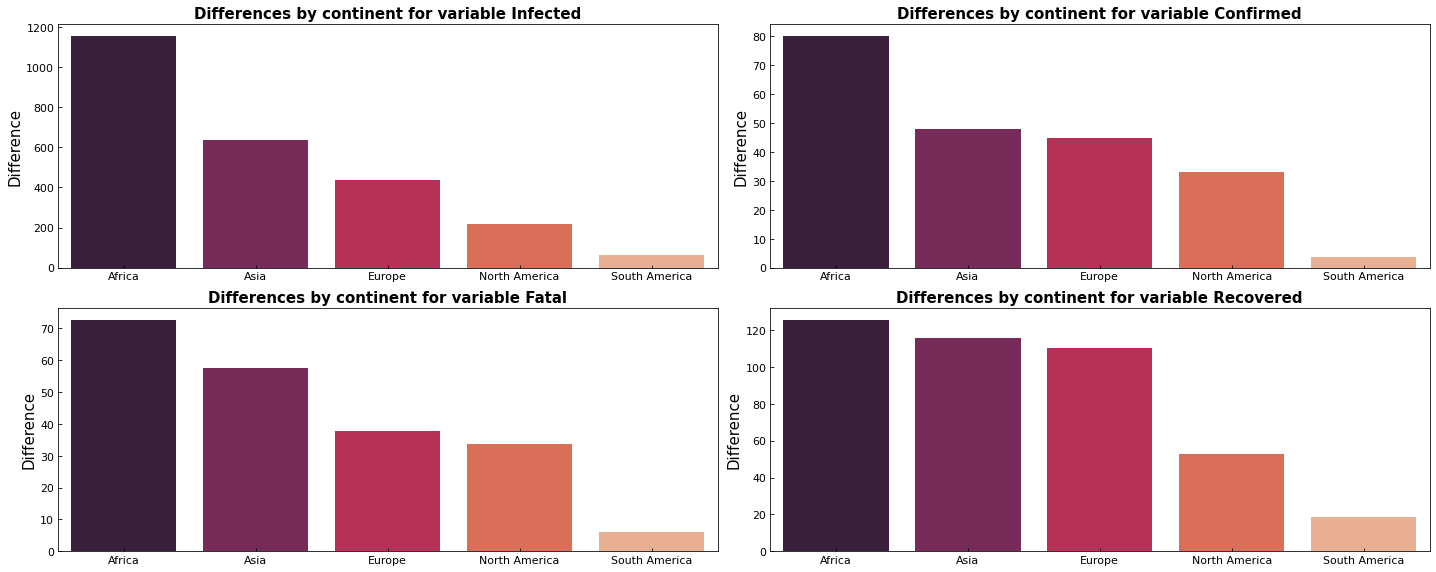

In [60]:
fig, axes = plt.subplots(2,2, figsize=(20,8))

for iIteration, iAx in enumerate(axes.flat):
    data = dv('log_sum', variables[iIteration], '60').reset_index().sort_values('Difference', ascending=False)
    sns.barplot(data=data.groupby('Continent').sum().reset_index().sort_values('Difference', ascending=False), x='Continent', y='Difference', ax=iAx, errwidth=0, palette=sns.color_palette('rocket', 5))
    iAx.set_xticklabels(data.groupby('Continent').sum().reset_index()['Continent'].apply(lambda k: pc.convert_continent_code_to_continent_name(k)))
    iAx.set_title(f"Differences by continent for variable {variables[iIteration]}", size=15, fontweight='bold')
    iAx.set_ylabel('Difference', size=15)
    iAx.set_xlabel(None)
    
fig.tight_layout(pad=0.8)

Africa seems to have the largest values for the dependent variable for this configuration. 

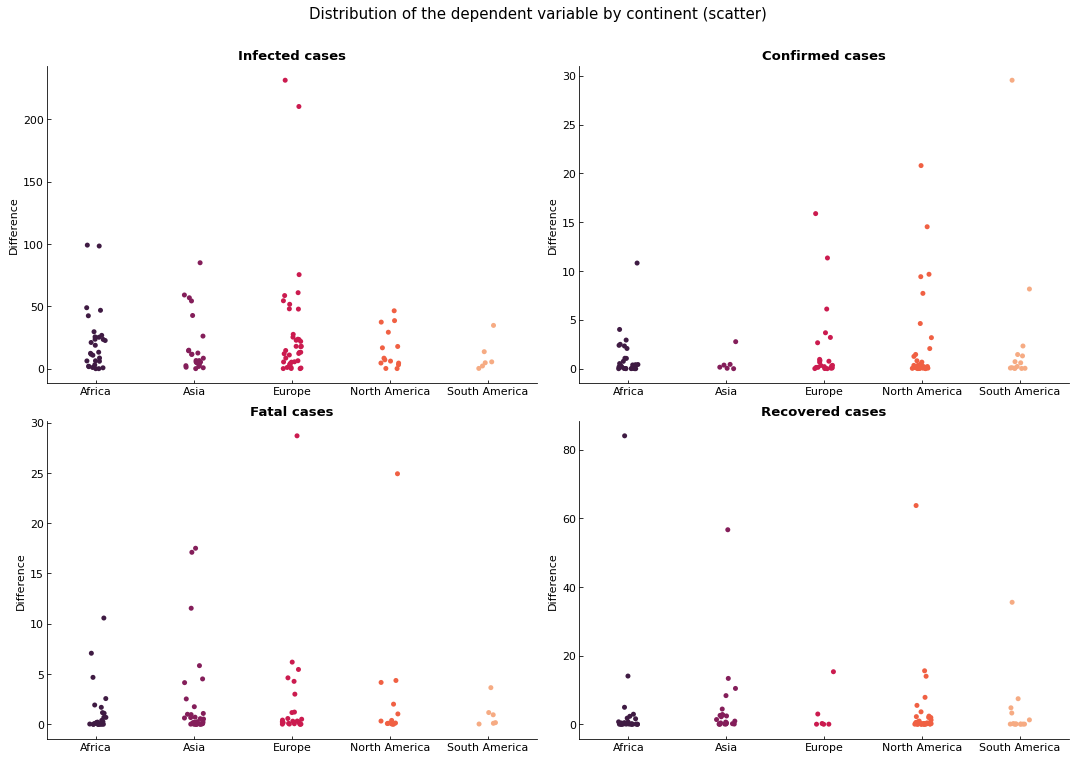

In [61]:
for iIteration, iVariable in enumerate(variables):
    exec(f"g{iIteration} = sns.catplot(data=dv('log_sum', iVariable, '60').reset_index().sort_values('Difference'), x='Continent', y='Difference', height=7, palette=sns.color_palette('rocket', 5))")

fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2, 2)

for iIteration, iGrid in enumerate(gs):
    exec(f"mg{iIteration} = sfg.SeabornFig2Grid(g{iIteration}, fig, iGrid)")
    
for iIteration, iAx in enumerate(fig.axes):
    iAx.set_title(f"{variables[iIteration]} cases", fontweight='bold')
    iAx.set_xticklabels(dv('log_sum', variables[iIteration], '60').reset_index().sort_values('Difference', ascending=False).groupby('Continent').sum().reset_index()['Continent'].apply(lambda k: pc.convert_continent_code_to_continent_name(k)))
    iAx.set_xlabel(None)
    
gs.tight_layout(fig, pad=0.8)
fig.suptitle('Distribution of the dependent variable by continent (scatter)', size=15, y=1.05)
plt.show()

An important aspect to keep in mind are outliers. For some outliers it may make sense to keep them in the sample, for some it may make sense to exclude them. In any case, it would make sense to investigate those outliers by checking their parameter estimation and the records of their actual data.

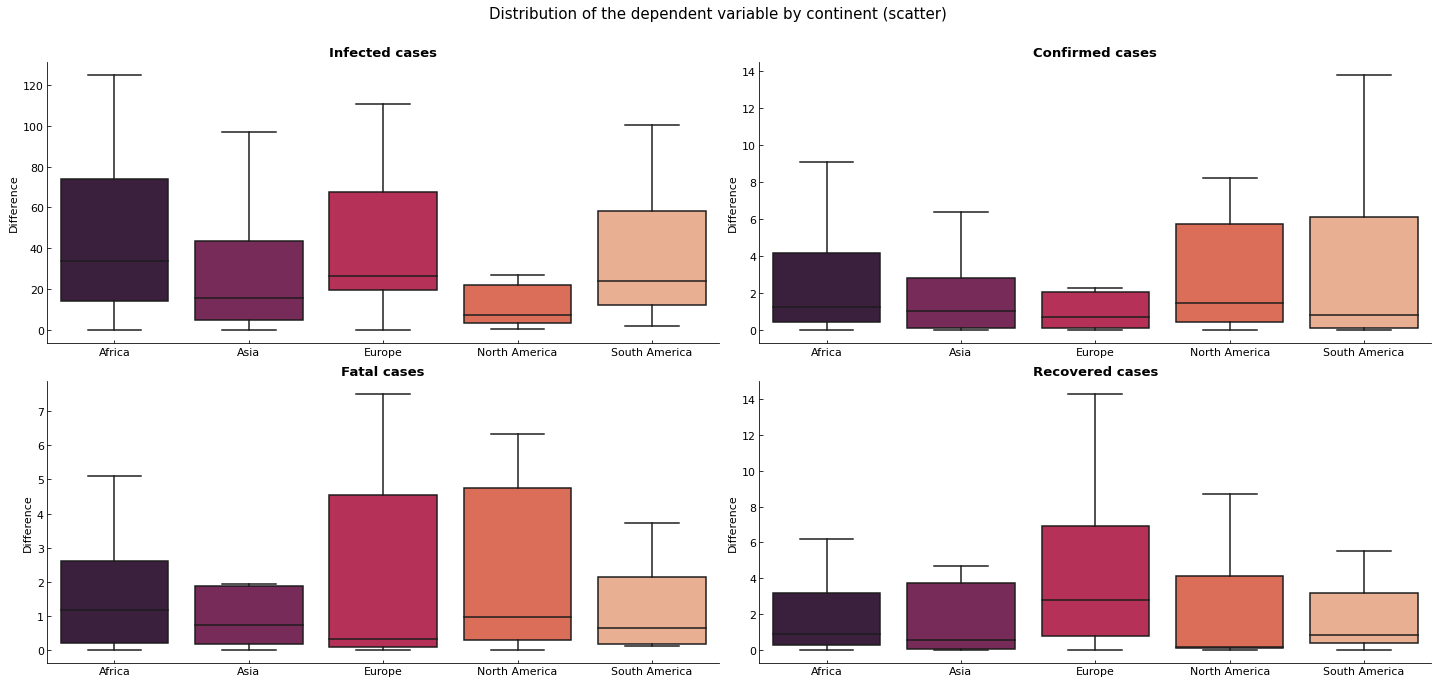

In [62]:
for iIteration, iVariable in enumerate(variables):
    exec(f"g{iIteration} = sns.catplot(data=dv('log_sum', iVariable, '90').reset_index().sort_values('Difference'), x='Continent', y='Difference', height=7, palette=sns.color_palette('rocket', 5), kind='box', showfliers = False)")

fig = plt.figure(figsize=(20,9))
gs = gridspec.GridSpec(2, 2)

for iIteration, iGrid in enumerate(gs):
    exec(f"mg{iIteration} = sfg.SeabornFig2Grid(g{iIteration}, fig, iGrid)")
    
for iIteration, iAx in enumerate(fig.axes):
    iAx.set_title(f"{variables[iIteration]} cases", fontweight='bold')
    iAx.set_xticklabels(dv('log_sum', variables[iIteration], '90').reset_index().sort_values('Difference', ascending=False).groupby('Continent').sum().reset_index()['Continent'].apply(lambda k: pc.convert_continent_code_to_continent_name(k)))
    iAx.set_xlabel(None)
    
gs.tight_layout(fig, pad=0.8)
fig.suptitle('Distribution of the dependent variable by continent (scatter)', size=15, y=1.05)
plt.show()

<a id="independent_variables"></a>
### Independent variables

A comprehensive collection of datasets from the Quality of Government Institute (QoG) from the University of Gothenburg is used to identify the regressors for our analysis. The QoG researchers developed the original datasets, which focuses on themes such as government quality, openness, and public administration. Data is supplied on a micro and subnational level. More information about the QoG as data source can be found on [their website](https://www.gu.se/en/quality-government/qog-data).

In [63]:
# Import of quality of governance dataset
qdf = pd.read_excel('../data/raw_data/qog_std_cs_jan21.xlsx')
qdf = qdf.set_index('ccodealp').drop(columns=['ccode', 'cname', 'ccodewb', 'version', 'ccodecow'])

cols = set([iCol.split('_')[0] for iCol in qdf.columns])
datasets = {}

for iCol in cols:
    datasets[iCol] = {}
    datasets[iCol]['regressors'] = qdf[qdf.columns[qdf.columns.str.startswith(iCol)]]

I introduce the following three variables that are being used as a proxy for government quality.

**Government quality variable 1: Ecological Footprint of Consumption**

While human societies are seriously endangered by environmental problems such as global warming and climate change, the government receives a crucial role in enacting effective and potentially costly environmental policies. However, the deployment of government policies and the spending on environmental issues ultimately requires the public support. In their study, Kulin and Seva ([2019](https://www.tandfonline.com/doi/full/10.1080/00207659.2019.1582964)) show that the likelihood of the government being supported by the public in environmental spending depends on government quality. They argue that governments are more likely to be encouraged by the public to implement potential costly environmental policies where government institutions are fair, effective, and non-corrupt. Their study suggests that as a consequence of weak support and intiative by the public, the ecological footprint of consumption of natural resources tends to increase where government quality is low. There are other studies that underscore the inverse relationship between government quality and ecological footprint. For example, Morse ([2006](http://www.ecologyandsociety.org/vol11/iss1/art22/)) finds that government corruption is negatively correlated with the globally recognized Environmental Sustainability Index. Similar findings are documented by Welsch ([2004](https://ideas.repec.org/p/diw/diwwpp/dp357.html)), Lopez and Mitra ([2000](https://ideas.repec.org/a/eee/jeeman/v40y2000i2p137-150.html)) and Damania, Fredriksson and List ([2003](https://ideas.repec.org/a/eee/jeeman/v46y2003i3p490-512.html))

$EFC = \text{Ecological Footprint of Consumption}$

For my regression, I use the ecological footprint of consumption as a proxy for government quality. Specifically, I select the variable of cropland consumption as this variable covers the most observations within my sample. The required data is provided by the [National Footprint Accounts](https://www.footprintnetwork.org/resources/data/) which measures the ecological resource use and resource capacity of nations over time. Based on approximately 6,000 data points per country per year, the Accounts calculate the Footprints of 232 countries, territories, and regions from 1961 to the present, providing the core data needed for all Ecological Footprint analysis worldwide.

**Government quality variable 2: Legislative Size**

While some people believe that greater political decentralization brings individualized fairness to population groups, Treisman ([2002](https://www.researchgate.net/publication/228707980_Decentralization_and_the_Quality_of_Government)) argues that countries with higher dispersions in legislative representations tend to experience higher levels of corruption and are associated with less effective provision of public healthcare services and infrastructure. Similar findings are reported by Britto and Fiorin ([2016](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2859940)) which find that the number of legislators is positively associated with the incidence of corruption detected during federal audits. He argues that an increase of the legislative size intensifies the competition for public resources among legislators each of which wants to fund projects that benefits her own voters. This consitutes a reason why legislators are incentivised to reduce corruption fighting efforts.

$LS = \text{Legislative Size}$

For my analysis, I use the legislative size as a proxy for government quality. I use a variable that measures the total number of directly elected representatives, excluding those appointed or indirectly elected. The required data is provided by the the Electoral System Design Database which is comprised of various reviews of the electoral legislation of countries from around the world. The database research was sourced from national legal documents from different sources, including the offcial web portals of governments, regional organizations that work in the area of democracy and electoral processes, and research institutes specialized in the area of elections and politics in general.

**Government quality variable 3: Political Globalization**

While there exist contradictory viewpoints on the effects of globalization on governments and societies, Khan ([2017](https://link.springer.com/article/10.1007/s11115-016-0352-4)) argues that globalization can lead to the loss of sovereignty by weakening the states causing low state capacity. In his study, he shows that political globalization is a significant predictor of the quality of government. Similar findings are documented by Darusalam, Said, Sohag and Janssen ([2019](https://rsucon.rsu.ac.th/files/proceedings/inter2019/IN19-222.pdf)) and Ezcurra (([2012](https://journals.sagepub.com/doi/abs/10.1068/c11234r))) which provide evidence for a negative relationship between globalization and quality of government.

$PG = \text{Political Globalization}$

For my regression, I use a measure of political globalization as a proxy for government quality. The variable measures the political globalization of a country on a scale from 1 to 100 with reference on membership of international organizations and international treaties. The required data is provided by the KOF Globalization Index which measures the economic, social and political dimension to globalization. It is used in order to monitor changes in the level of globalization of different countries over extended periods of time. The current KOF Globalization Index is available for 185 countries and covers the period from 1970 until 2018.

<a id="multiple_linear_regression_model"></a>
### Multiple linear regression model

The first model is a multiple linear regression estimated according to OLS. I implement a model configuration where I calculate the regressand based on the variable 'Infected' and calculate an a absolute difference between predicted and actual cases over a 150 day time window.

In [64]:
modelsDict = {}

In [65]:
reg = pd.merge(dv('absolute_sum','Infected','150'), datasets['ef']['regressors']['ef_crop'], left_on=['Country'], right_index=True).drop(columns=[])
reg = pd.merge(reg, datasets['ideaesd']['regressors']['ideaesd_lsde'], left_on=['Country'], right_index=True).drop(columns=[])
reg = pd.merge(reg, datasets['dr']['regressors']['dr_pg'], left_on=['Country'], right_index=True)
reg = reg.applymap(lambda k: pd.to_numeric(k, errors='coerce'))
reg = reg.replace([np.inf, -np.inf], np.nan)
copy_mu = reg.copy()
reg = reg.fillna(reg.median())
Y = reg['Difference'].to_frame()
X = reg.iloc[:, 1:]

selector = SelectKBest(f_regression, k=3)
selector.fit_transform(X, Y)
X_new = X.iloc[:,selector.get_support(indices=True)]

reg = reg[['Difference']+ X_new.columns.tolist()]

model = sm.OLS(Y, sm.add_constant(X_new)).fit()
modelsDict['Linear model'] = {}
modelsDict['Linear model']['model'] = model
modelsDict['Linear model']['reg'] = reg
model.summary(yname='$AD_{t=150}^{v=I}$', xname=['$Intercept$', '$EFC$', '$LS$', '$PG$'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     $AD_{t=150}^{v=I}$   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     18.26
Date:                Tue, 08 Jun 2021   Prob (F-statistic):           1.22e-08
Time:                        21:03:49   Log-Likelihood:                -1111.3
No. Observations:                  67   AIC:                             2231.
Df Residuals:                      63   BIC:                             2239.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
$Intercept$ -3.076e+06   1.93e+06     -1.592      0.116   -6.94e+06    7.84e+05
$EFC$        9.268e+06   2.54e+06      3.656      0.001     4.2e+06    1.43e+07
$LS$         2.335e+04   4405.141      5.301      0.000    1.45e+04    3.22e+04
$PG$        -6.767e+04   3.62e+04     -1.867      0.067    -1.4e+05    4753.222
==============================================================================
Omnibus:                       41.340   Durbin-Watson:                   2.561
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.849
Skew:                           1.684   Prob(JB):                     8.84e-40
Kurtosis:                      10.286   Cond. No.                     1.36e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<a id="multiple_linear_regression_model_with_continent_fixed_effects"></a>
### Multiple linear regression model with continent fixed effects

The second model is a multiple regression in linear form with continent fixed effects. I implement a model configuration where I calculate the regressand based on the variable 'Infected' and calculate an a absolute difference between predicted and actual cases over a 120 day time window.

In [66]:
continentsDict = ['AF', 'AS', 'EU', 'NA', 'SA']
dummiesList = [f'Continent_{c}' for c in continentsDict]

In [67]:
reg = pd.merge(dv('absolute_sum','Infected','120'), datasets['ef']['regressors']['ef_crop'], left_on=['Country'], right_index=True).drop(columns=[])
reg = pd.merge(reg, datasets['ideaesd']['regressors']['ideaesd_lsde'], left_on=['Country'], right_index=True).drop(columns=[])
reg = pd.merge(reg, datasets['dr']['regressors']['dr_pg'], left_on=['Country'], right_index=True)
reg = reg.applymap(lambda k: pd.to_numeric(k, errors='coerce'))
reg = reg.replace([np.inf, -np.inf], np.nan)
reg = reg.fillna(reg.median())
Y = reg['Difference'].to_frame()
X = reg.iloc[:, 1:]

selector = SelectKBest(f_regression, k=3)
selector.fit_transform(X, Y)
X_new = X.iloc[:,selector.get_support(indices=True)]

reg = reg[['Difference']+ X_new.columns.tolist()]

model = smf.ols(formula = 'Difference ~ ' + ' + '.join(X_new.columns) + ' + ' + ' + '.join(dummiesList), data=pd.get_dummies(reg.reset_index(), columns=['Continent'])).fit()

modelsDict['Fixed effects model'] = {}
modelsDict['Fixed effects model']['model'] = model
modelsDict['Fixed effects model']['reg'] = reg
model.summary(yname='$AD_{t=120}^{v=I}$', xname=['$Intercept$', '$EFC$', '$LS$', '$PG$', '$D_{AF}$', '$D_{AS}$', '$D_{EU}$', '$D_{NA}$', '$D_{SA}$'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     $AD_{t=120}^{v=I}$   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     8.387
Date:                Tue, 08 Jun 2021   Prob (F-statistic):           1.55e-07
Time:                        21:03:55   Log-Likelihood:                -1382.1
No. Observations:                  83   AIC:                             2780.
Df Residuals:                      75   BIC:                             2800.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
$Intercept$ -1.678e+06   2.04e+06     -0.822      0.414   -5.75e+06    2.39e+06
$EFC$        7.156e+06   2.98e+06      2.404      0.019    1.23e+06    1.31e+07
$LS$         2.221e+04   4348.127      5.108      0.000    1.35e+04    3.09e+04
$PG$        -6.504e+04   3.83e+04     -1.700      0.093   -1.41e+05    1.12e+04
$D_{AF}$    -1.407e+06   9.01e+05     -1.562      0.123    -3.2e+06    3.88e+05
$D_{AS}$    -7.732e+05   9.37e+05     -0.825      0.412   -2.64e+06    1.09e+06
$D_{EU}$     5.578e+05   1.41e+06      0.397      0.693   -2.24e+06    3.36e+06
$D_{NA}$     1.703e+06   1.18e+06      1.437      0.155   -6.57e+05    4.06e+06
$D_{SA}$    -1.758e+06   1.66e+06     -1.060      0.293   -5.06e+06    1.55e+06
==============================================================================
Omnibus:                       51.504   Durbin-Watson:                   2.432
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.832
Skew:                           1.875   Prob(JB):                     8.34e-53
Kurtosis:                      10.436   Cond. No.                     3.24e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.4e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<a id="multiple_linear_regression_model_with_interaction_effects"></a>
### Multiple linear regression model with interaction effects

The last model is a multiple regression with interaction effects I implement a model configuration where I calculate the regressand based on the variable 'Infected' and calculate an a absolute difference between predicted and actual cases over a 150 day time window.

In [68]:
# Potential datasets for interactions
reg = pd.merge(dv('absolute_sum','Infected','150'), datasets['egov']['regressors'], left_on=['Country'], right_index=True).drop(columns=[])
reg = pd.merge(reg, datasets['ef']['regressors']['ef_crop'], left_on=['Country'], right_index=True).drop(columns=[])
reg = pd.merge(reg, datasets['ideaesd']['regressors']['ideaesd_lsde'], left_on=['Country'], right_index=True).drop(columns=[])
reg = pd.merge(reg, datasets['dr']['regressors']['dr_pg'], left_on=['Country'], right_index=True)

reg = reg.applymap(lambda k: pd.to_numeric(k, errors='coerce'))
reg = reg.replace([np.inf, -np.inf], np.nan)
reg = reg.fillna(reg.median())
Y = reg['Difference'].to_frame()
X = reg.iloc[:, 1:]

# Identifying the best interaction
X_int = pd.DataFrame(PolynomialFeatures(2, interaction_only=True, include_bias=False).fit_transform(X), columns = list(X.columns) + list(itertools.combinations(X.columns, 2)))
X_int.index = Y.index
selector = SelectKBest(f_regression, k=1)
selector.fit_transform(X_int, Y)
X_int = X_int.iloc[:,selector.get_support(indices=True)]
X_int.columns = [x[0] + '_' + x[1] if type(x) == tuple else x for x in X_int.columns]
X_int

ef_crop_ideaesd_lsde
Continent Country                      
AF        AGO                 69.808424
          BFA                 62.298428
          BWA                 16.763298
          COM                 13.589155
          DZA                290.160380
...                                 ...
NA        SLV                 39.873018
          TTO                 17.529177
SA        ARG                239.576323
          CHL                 85.819227
          VEN                 38.824071

[67 rows x 1 columns]

An interaction effect between ecological footprint and legislative size seems to be the best predictor to explain the variance of the dependent variable.

In [69]:
reg = pd.merge(dv('absolute_sum','Infected','150'), datasets['dr']['regressors']['dr_pg'], left_on=['Country'], right_index=True)
reg = pd.merge(reg, X_int, left_index=True, right_index=True)
reg = reg.applymap(lambda k: pd.to_numeric(k, errors='coerce'))
reg = reg.replace([np.inf, -np.inf], np.nan)
reg = reg.fillna(reg.median())
Y = reg['Difference'].to_frame()
X = reg.iloc[:, 1:]

selector = SelectKBest(f_regression, k=2)
selector.fit_transform(X, Y)
X_new = X.iloc[:,selector.get_support(indices=True)]

reg = reg[['Difference']+ X_new.columns.tolist()]

model = smf.ols(formula = 'Difference ~ ' + ' + '.join(X_new.columns) + ' + ' + ' + '.join(dummiesList), data=pd.get_dummies(reg.reset_index(), columns=['Continent'])).fit()

modelsDict['Interaction model'] = {}
modelsDict['Interaction model']['model'] = model
modelsDict['Interaction model']['reg'] = reg
model.summary(yname='$AD_{t=150}^{v=I}$', xname=['$Intercept$', '$PG$', '$EFCxLS$', '$D_{AF}$', '$D_{AS}$', '$D_{EU}$', '$D_{NA}$', '$D_{SA}$'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     $AD_{t=150}^{v=I}$   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     18.08
Date:                Tue, 08 Jun 2021   Prob (F-statistic):           7.54e-12
Time:                        21:04:01   Log-Likelihood:                -1097.7
No. Observations:                  67   AIC:                             2209.
Df Residuals:                      60   BIC:                             2225.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
$Intercept$  2.189e+06   1.55e+06      1.414      0.163   -9.09e+05    5.29e+06
$PG$        -8.137e+04   2.94e+04     -2.763      0.008    -1.4e+05   -2.25e+04
$EFCxLS$     4.156e+04   4945.763      8.402      0.000    3.17e+04    5.14e+04
$D_{AF}$    -7.502e+05   7.85e+05     -0.955      0.343   -2.32e+06     8.2e+05
$D_{AS}$      1.06e+06   8.18e+05      1.296      0.200   -5.76e+05     2.7e+06
$D_{EU}$      1.35e+06   9.66e+05      1.397      0.168   -5.83e+05    3.28e+06
$D_{NA}$     3.511e+05   1.07e+06      0.329      0.743   -1.78e+06    2.48e+06
$D_{SA}$     1.784e+05   1.76e+06      0.102      0.919   -3.33e+06    3.69e+06
==============================================================================
Omnibus:                       21.021   Durbin-Watson:                   2.615
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.948
Skew:                           0.706   Prob(JB):                     1.18e-17
Kurtosis:                       8.092   Cond. No.                     2.89e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.51e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<a id="regression_diagnostics"></a>
### Regression diagnostics

**Normal Q-Q Plot**  
The Q-Q plot constitutes a visual tool which helps us to assess if a set of datapoints comes from a theoretical distribution such as the normal distribubtion. By running a multiple regression on a dependent variable, we implicitly assume that this variable is normally distributed, hence we can use a Normal Q-Q plot to check that assumption. 

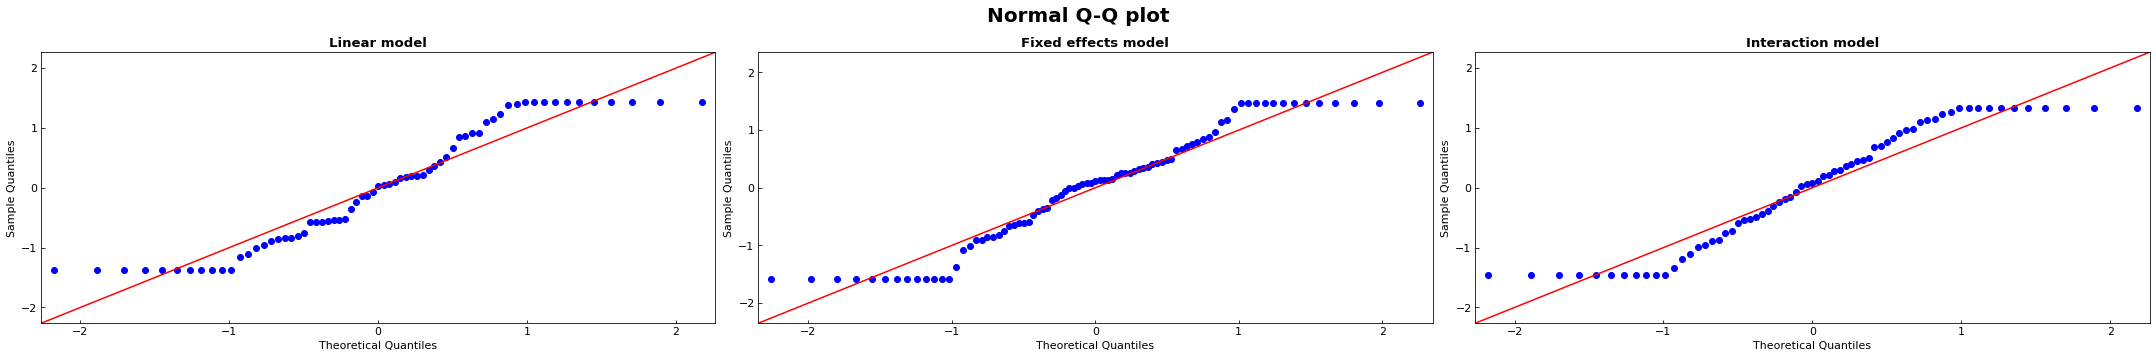

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(30,5))

for iIteration, iModel in enumerate(modelsDict):
    
    sm.qqplot(scipy.stats.mstats.winsorize(modelsDict[iModel]['model'].resid, limits=(0.15,0.15)), stats.t, distargs=(4,), fit=True, ax=axes[iIteration], line='45', )
    axes[iIteration].set_title(iModel, fontweight='bold')

fig.suptitle('Normal Q-Q plot', size=20, fontweight='bold')
fig.tight_layout(pad=0.8)

The distribution of the dependent variable in all models differs from the theoretical quantiles of the normal distribution indicating the presence of lighter tails.

**Heteroscedasticity tests**  
A heteroscedasticity test plots the fitted values against its residuals. If we run a multiple regression, we make the implicit assumption of the absence of heteroscedasticity. By checking the fit-residuals plot, we can verify the absence of heteroscedasticity if the spread of the residuals is roughly identical for all levels of fitted values and if this spread does not follow a identifiable pattern. Hence, we can look at the plots and see whether this condition is true.

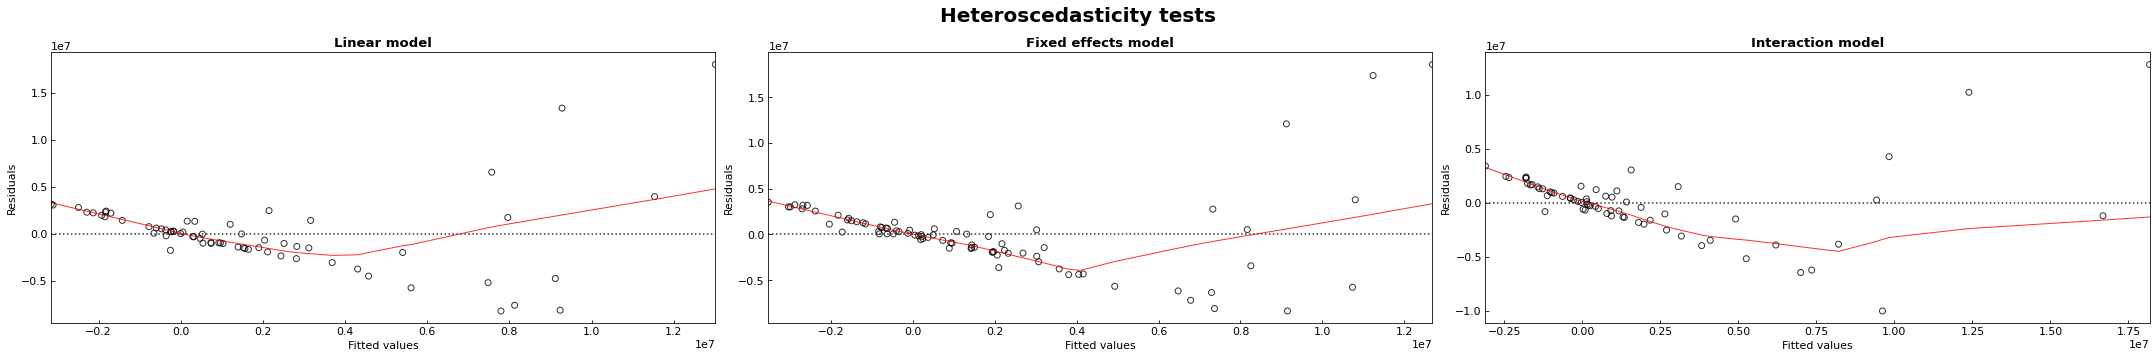

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(30, 5))

for iIteration, iModel in enumerate(modelsDict):
    
    sns.residplot(modelsDict[iModel]['model'].fittedvalues, 'Difference', data=modelsDict[iModel]['reg'], lowess=True, 
                  scatter_kws={'facecolors':'none', 'edgecolors':'black'}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=axes[iIteration])  
    axes[iIteration].set_ylabel('Residuals')
    axes[iIteration].set_xlabel('Fitted values')
    axes[iIteration].set_title(iModel, fontweight='bold')

fig.suptitle('Heteroscedasticity tests', size=20, fontweight='bold')
fig.tight_layout(pad=0.8)

The fitted red line indicates the presence of an observable pattern. Also, it is notable that the spread of residuals tends to increase for higher levels of fitted values. These results indicate that the regression models might suffer from a heteroscedasticity problem.

**Scale-Location test**  
In practice, the scale-location test is often used as a complement to the usual fit-residuals plot. The scale-location test plots the standardized residuals against the fitted values. Standardized residuals are simply raw residuals which were standardized by an own estimated standard error.

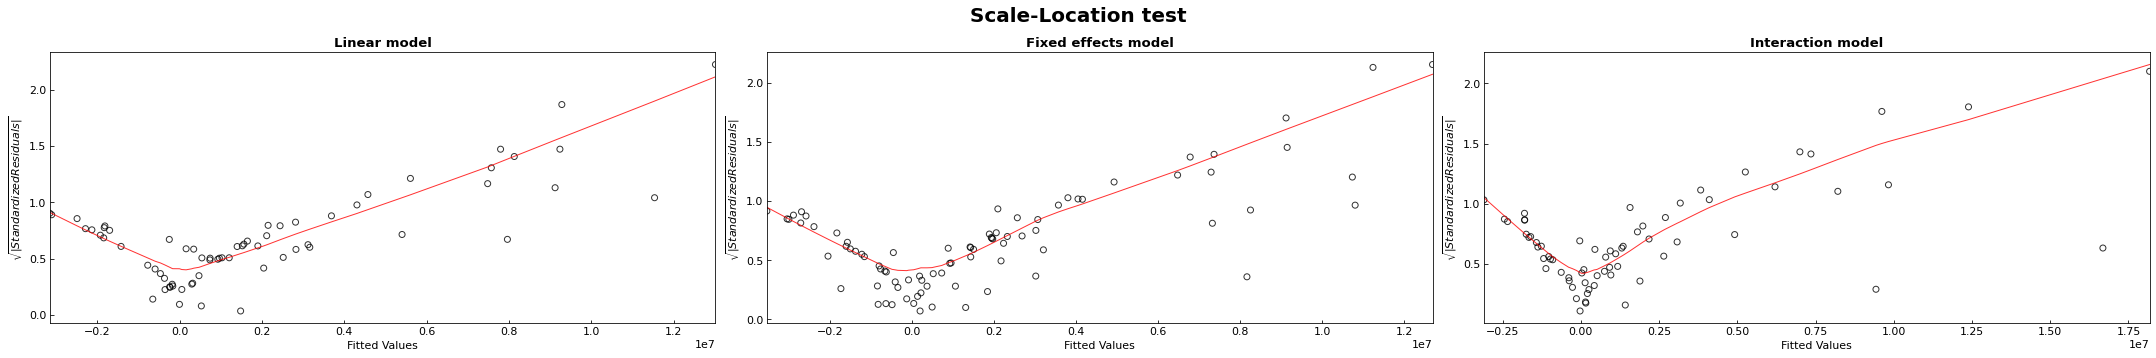

In [85]:
fig, axes = plt.subplots(1, 3, figsize=(30, 5))

for iIteration, iModel in enumerate(modelsDict):
    
    sns.regplot(modelsDict[iModel]['model'].fittedvalues, 
           np.sqrt(np.abs(modelsDict[iModel]['model'].get_influence().resid_studentized_internal)), 
            scatter=True, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
          scatter_kws={'facecolors':'none', 'edgecolors':'black'}, ax=axes[iIteration])
    axes[iIteration].set_title(iModel, fontweight='bold')
    axes[iIteration].set_xlabel('Fitted Values')
    axes[iIteration].set_ylabel('$\sqrt{|Standardized Residuals|}$')

fig.suptitle('Scale-Location test', size=20, fontweight='bold')
fig.tight_layout(pad=0.8)

The visual tests confirm our findings from the fit-residuals test. We see the observable pattern and an increase in the variance of the residuals, an indication for heteroscedasticity. We can further confirm this finding with a quantitative assessment by implementing the Breusch-Pagan test.

In [86]:
het = pd.DataFrame(columns=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

for iModel in modelsDict:
    het.loc[iModel] = np.array(sm.stats.het_breuschpagan(modelsDict[iModel]['model'].resid, modelsDict[iModel]['model'].model.exog))
    
het

,Lagrange multiplier statistic,p-value,f-value,f p-value
Linear model,26.478582,0.000008,13.722378,5.441745e-07
Fixed effects model,32.362470,0.000080,6.847505,2.735347e-06
Interaction model,33.103974,0.000025,9.766329,1.713775e-07


The Breusch-Pagan test confirms our visual assessments. The regression models suffer from heteroscedastictiy.

**Multicollinearity tests**

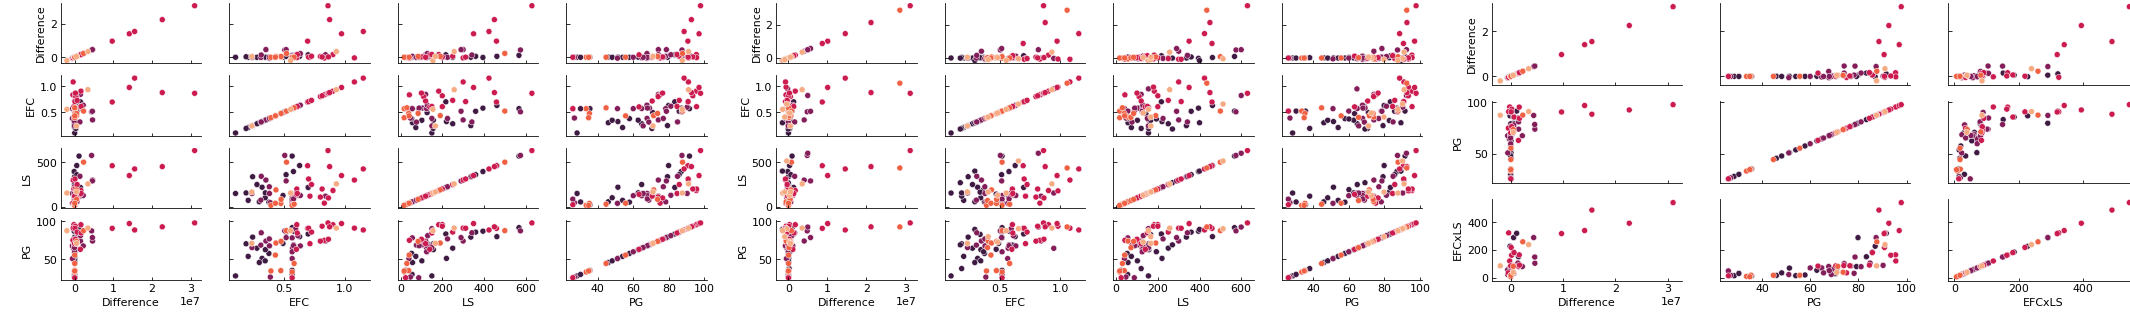

In [87]:
g0 = sns.PairGrid(modelsDict['Linear model']['reg'].reset_index().rename(columns={'ef_crop':'EFC','ideaesd_lsde':'LS','dr_pg':'PG'}), hue='Continent', palette=sns.color_palette('rocket', 5)).map(sns.scatterplot)
g1 = sns.PairGrid(modelsDict['Fixed effects model']['reg'].reset_index().rename(columns={'ef_crop':'EFC','ideaesd_lsde':'LS','dr_pg':'PG'}), hue='Continent', palette=sns.color_palette('rocket', 5)).map(sns.scatterplot)
g2 = sns.PairGrid(modelsDict['Interaction model']['reg'].reset_index().rename(columns={'dr_pg':'PG','ef_crop_ideaesd_lsde':'EFCxLS'}), hue='Continent', palette=sns.color_palette('rocket', 5)).map(sns.scatterplot)

fig = plt.figure(figsize=(30,5))
gs = gridspec.GridSpec(1, 3)

mg0 = sfg.SeabornFig2Grid(g0, fig, gs[0])
mg1 = sfg.SeabornFig2Grid(g1, fig, gs[1])
mg2 = sfg.SeabornFig2Grid(g2, fig, gs[2])

gs.tight_layout(fig, pad=2)
plt.show()

The plots reveal some patterns that might indicate the presence of multicollinearity. The variance inflation factor will give me a quantitative assessment of whether multicollinearity is a problem in my regressions or not.

In [88]:
vif = pd.DataFrame(columns=['Variable 1', 'Variable 2', 'Variable 3'])

for iModel in modelsDict:
    X = modelsDict[iModel]['reg'].iloc[:,1:]
    vif_array = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    vif.loc[iModel] = vif_array + [np.nan] * (3 - len(vif_array))
    
vif

,Variable 1,Variable 2,Variable 3
Linear model,9.259505,4.384761,14.449301
Fixed effects model,8.658567,4.343669,13.123896
Interaction model,2.871376,2.871376,NaN


By applying the variance inflation factor, we regress each independent variable on all other independent variables while the factor is calculated as $\frac{1}{1-R^2}$. Hence, a great factor indicates a strong correlation. Generally, a factor above 5 indicates high multicollinearity. For my regressions, it seems that I have alleviated the problem of multicollinearity to an extent by imlpementing interaction effects.

<a id="scenario_analysis"></a>
## Scenario analysis

The final section of the empirical analysis part provides simulations of COVID-19 numbers for Switzerland. I use the best trained parameters over the entire time series which is available and I estimate the scenario cases for the variables Confirmed, Infected, Fatal and Recovered. 

**Adding scenarios**

In [79]:
# Basis scenario
country = 'CHE'
eval(country).add(days=360, name="Basis")

# Lockdown scenario
rhoLockdown = eval(country).get("rho", phase="last") * 0.5
eval(country).add(days=360, name="Lockdown", rho=rhoLockdown)

# Medicine scenario
kappaMedicine = eval(country).get("kappa", phase="last") * 0.5
sigmaMedicine = eval(country).get("sigma", phase="last") * 2
eval(country).add(days=360, name="Medicine", kappa=kappaMedicine, sigma=sigmaMedicine)

# Vaccine scenario
rhoVaccine = eval(country).get("rho", phase="last") * 0.8
kappaVaccine = eval(country).get("kappa", phase="last") * 0.6
sigmaVaccine = eval(country).get("sigma", phase="last") * 1.2
eval(country).add(days=360, name="Vaccine",  rho=rhoVaccine, kappa=kappaVaccine, sigma=sigmaVaccine)

**Simulating scenarios**

In [80]:
# Simulate the number of cases
variables = {'C':'Confirmed', 'I':'Infected', 'F':'Fatal', 'R':'Recovered'}
scenarios = ['Basis', 'Lockdown', 'Medicine', 'Vaccine']

for iScenario in scenarios:
    exec(f"{iScenario} = eval(country).simulate(name='{iScenario}', variables = ['Confirmed', 'Infected', 'Fatal', 'Recovered'], show_figure=False)")

for iVariable in variables:
    
    exec(f"{iVariable} = eval(scenarios[0])[[variables[iVariable], 'Date']]")
    exec(f"{iVariable}.columns = ['Basis', 'Date']")
    
    for iScenario in scenarios[1:]:
        to_merge = eval(iScenario)[[variables[iVariable], 'Date']]
        to_merge.columns = [iScenario, 'Date']
        exec(f"{iVariable} = pd.merge({iVariable}, to_merge, left_on='Date', right_on='Date')")
    

**Visualization**

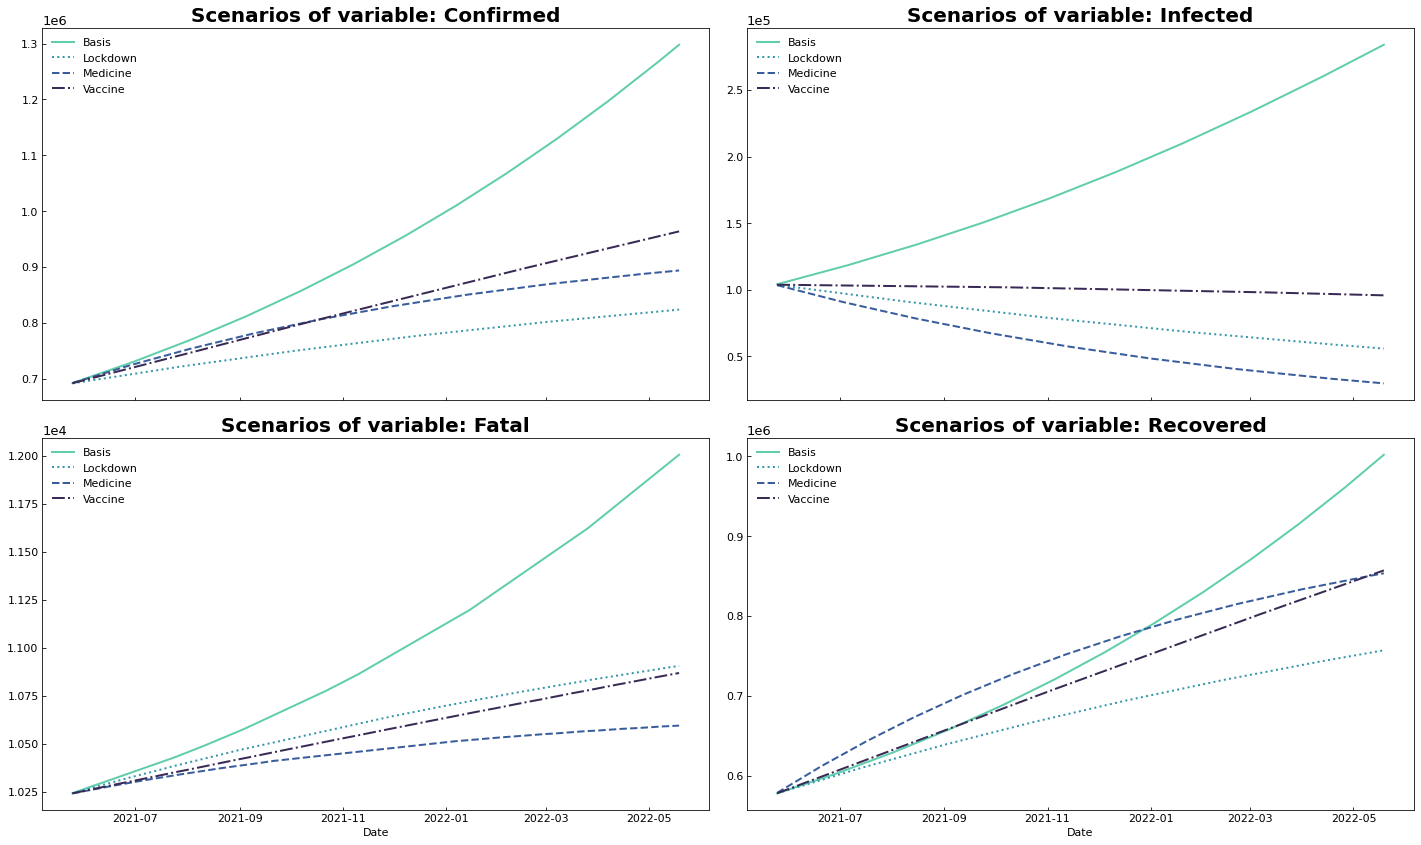

In [89]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(20, 12), sharex=True)

for iIteration, iVariable in enumerate(variables):
    
    df = eval(iVariable).tail(360)
    sns.lineplot(x='Date', y='value', hue='variable', data=pd.melt(df, ['Date']), ax=eval(f'ax{iIteration}'), palette=sns.color_palette("mako_r", 4), sizes=10, linewidth=2)
    eval(f'ax{iIteration}.set_title("Scenarios of variable: {variables[iVariable]}", size=20, fontweight="bold")')
    eval(f'ax{iIteration}.set_ylabel(None)')
    eval(f'ax{iIteration}.ticklabel_format(axis="y", style="sci", scilimits=(0,0))')
    exec(f'exponent = ax{iIteration}.yaxis.get_offset_text()')
    eval(f'exponent.set_size(13)')
    
    for iLinestyle, iLine in eval(f"zip(('solid', 'dotted', 'dashed', 'dashdot'), ax{iIteration}.lines)"):
        iLine.set_linestyle(iLinestyle)
    
    eval(f"ax{iIteration}.legend([line for line in ax{iIteration}.lines], ['Basis', 'Lockdown', 'Medicine', 'Vaccine'])")

fig.tight_layout(pad=1.5)

<a id="conclusion"></a>
# Conclusion

In this study, I examined the impact of government quality on the efficiacy of government interventions and predicted how the coronavirus situation in Switzerland would change over the next 360 days if a lockdown would be imposed or drugs and vaccines would be administered in May 2021. I provide evidence that the government quality variables ecological footprint of consumption, legislative size and political globalization decreases have a significant impact on the efficiacy of coronavirus government interventions. Furthermore, my findings show that a lockdown, medicine and vaccine today would considerably curb the coronavirus epidemic in Switzerland over the next year.

My results have important policy implications, namely that government interventions to dampen the spread of the coronavirus depend on the quality of the government and the coronavirus epidemic's negative impact on public health in Switzerland could be further alleviated if effective medicines would be available or another lockdown would be imposed.